# 1. Setup

In [1]:
%load_ext watermark

from glob import glob
import numpy as np
import cftime
import pandas as pd
import xarray as xr
from scipy.stats import linregress
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean.cm as cmo

%watermark -iv -co -v

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.2.0

conda environment: cpl_ppe_co2

cartopy   : 0.24.1
cmocean   : 4.0.3
cftime    : 1.6.4
numpy     : 2.0.1
matplotlib: 3.9.1
pandas    : 2.2.2
xarray    : 2025.4.0
sys       : 3.12.10 | packaged by conda-forge | (main, Apr 10 2025, 22:21:13) [GCC 13.3.0]



In [2]:
xr.set_options(display_expand_attrs=False, display_expand_data=False);
plt.rcParams['figure.dpi'] = 120;

In [3]:
# default simulation of historical prescribed-SST PPE
hist_dir = "/glade/derecho/scratch/bbuchovecky/archive"
hist_case = "f.e22.FHIST_BGC.f19_f17_mg17.coupPPE-hist.000"

# 3 member ensemble of historical prescribed-SST CMIP simulations
cmip_dir = "/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6"
cmip_case = "f.e21.FHIST_BGC.f19_f19_mg17.CMIP6-AMIP-2deg"

# default simulation of preindustrial slab ocean PPE (Claire's PPE)
piso_dir = "/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations"
piso_case = "COUP0000_PI_SOM"

In [4]:
lnd_var = "HR"
atm_var = "Z3"

print("my historical simulation:")
print(sorted(glob(f"{hist_dir}/{hist_case}/lnd/proc/tseries/month_1/*h0*{lnd_var}*.nc")))
print(sorted(glob(f"{hist_dir}/{hist_case}/atm/proc/tseries/month_1/*h0*{atm_var}*.nc")))

print("\nCMIP:")
print(sorted(glob(f"{cmip_dir}/{cmip_case}.001/lnd/proc/tseries/month_1/*h0*{lnd_var}*.nc")))
print(sorted(glob(f"{cmip_dir}/{cmip_case}.001/atm/proc/tseries/month_1/*h0*{atm_var}*.nc")))

print("\nClaire's preindustrial simulation:")
print(sorted(glob(f"{piso_dir}/{piso_case}/lnd/proc/tseries/*{lnd_var}*.nc")))
print(sorted(glob(f"{piso_dir}/{piso_case}/atm/proc/tseries/*{atm_var}*.nc")))

my historical simulation:
['/glade/derecho/scratch/bbuchovecky/archive/f.e22.FHIST_BGC.f19_f17_mg17.coupPPE-hist.000/lnd/proc/tseries/month_1/f.e22.FHIST_BGC.f19_f17_mg17.coupPPE-hist.000.clm2.h0.HR.195001-201412.nc', '/glade/derecho/scratch/bbuchovecky/archive/f.e22.FHIST_BGC.f19_f17_mg17.coupPPE-hist.000/lnd/proc/tseries/month_1/f.e22.FHIST_BGC.f19_f17_mg17.coupPPE-hist.000.clm2.h0.HR_vr.195001-201412.nc', '/glade/derecho/scratch/bbuchovecky/archive/f.e22.FHIST_BGC.f19_f17_mg17.coupPPE-hist.000/lnd/proc/tseries/month_1/f.e22.FHIST_BGC.f19_f17_mg17.coupPPE-hist.000.clm2.h0.LITTERC_HR.195001-201412.nc', '/glade/derecho/scratch/bbuchovecky/archive/f.e22.FHIST_BGC.f19_f17_mg17.coupPPE-hist.000/lnd/proc/tseries/month_1/f.e22.FHIST_BGC.f19_f17_mg17.coupPPE-hist.000.clm2.h0.QHR.195001-201412.nc', '/glade/derecho/scratch/bbuchovecky/archive/f.e22.FHIST_BGC.f19_f17_mg17.coupPPE-hist.000/lnd/proc/tseries/month_1/f.e22.FHIST_BGC.f19_f17_mg17.coupPPE-hist.000.clm2.h0.SOILC_HR.195001-201412.nc']


In [5]:
variables = {
    "atm": ["TREFHT", "LHFLX"],
    # "lnd": ["TLAI", "GPP", "HTOP", "TSA", "WOODC", "LEAFC", "FROOTC", "LIVESTEMC", "DEADSTEMC", "LIVECROOTC", "DEADCROOTC", "TOTLITC", "CWDC", "TOTVEGC", "TOTECOSYSC", "HR", "TOTSOMC"],
    "lnd": ["TLAI", "GPP", "HTOP", "TSA"],
}

start_year = 1950
end_year = 2014
times = np.array([cftime.DatetimeNoLeap(year, month, 1)
                  for year in range(start_year, end_year + 1)
                  for month in range(1, 13)])

cmip = dict()
hist = dict()
piso = dict()

for comp, vars in variables.items():
    for v in vars:
        print(v)

        hist[v] = xr.open_mfdataset(f"{hist_dir}/{hist_case}/{comp}/proc/tseries/month_1/*h0*.{v}.*.nc")[v].sel(time=slice("1950-01", "2015-01"))
        assert len(times) == hist[v].sizes["time"]
        hist[v] = hist[v].assign_coords(time=times)
        if comp == "lnd":
            hist[v] = hist[v].reindex_like(hist[variables["atm"][0]], method="nearest", tolerance=1e-3)

        if glob(f"{piso_dir}/{piso_case}/{comp}/proc/tseries/*h0*{v}.nc"):
            piso[v] = xr.open_mfdataset(f"{piso_dir}/{piso_case}/{comp}/proc/tseries/*h0*{v}.nc")[v].sel(time=slice("0100-01", "0188-12")).reindex(lat=hist[variables["atm"][0]].lat, lon=hist[variables["atm"][0]].lon, method="nearest", tolerance=1e-3)
            if comp == "lnd":
                piso[v] = piso[v].reindex(lat=hist[variables["atm"][0]].lat, lon=hist[variables["atm"][0]].lon, method="nearest", tolerance=1e-3)
        
        cmip_list = []
        for i in range(3):
            cmip_tmp = xr.open_mfdataset(f"{cmip_dir}/{cmip_case}.00{i+1}/{comp}/proc/tseries/month_1/*h0*.{v}.*.nc")[v].sel(time=slice("1950-01", "2015-01"))
            assert len(times) == cmip_tmp.sizes["time"]
            cmip_tmp = cmip_tmp.assign_coords(time=times)
            cmip_list.append(cmip_tmp.reindex_like(hist[v], method="nearest", tolerance=1e-3))
        cmip[v] = cmip_list
    
cmip_tmp = xr.open_mfdataset(f"{cmip_dir}/{cmip_case}.001/lnd/proc/tseries/month_1/*h1*.HTOP.*.nc").isel(time=0).reindex_like(hist[variables["atm"][0]], method="nearest", tolerance=1e-3)
cmip["landarea"] = cmip_tmp["area"] * cmip_tmp["landfrac"]
cmip["landweights"] = cmip["landarea"] / cmip["landarea"].sum(dim=["lat", "lon"])

hist_tmp = xr.open_mfdataset(f"{hist_dir}/{hist_case}/lnd/proc/tseries/month_1/*h1*.HTOP.*.nc").reindex(lat=hist[variables["atm"][0]].lat, lon=hist[variables["atm"][0]].lon, method="nearest", tolerance=1e-3)
hist["landarea"] = hist_tmp["area"] * hist_tmp["landfrac"]
hist["landweights"] = hist["landarea"] / hist["landarea"].sum(dim=["lat", "lon"])

piso["landarea"] = hist["landarea"]
piso["landweights"] = hist["landweights"]

area = xr.open_mfdataset(f"{cmip_dir}/{cmip_case}.001/atm/proc/tseries/month_1/*h0*.AREA.*.nc")["AREA"].isel(time=-1).reindex_like(hist[variables["atm"][0]], method="nearest", tolerance=1e-3)
areaweights = area / area.sum(dim=["lat", "lon"])

cmip["areaweights"] = areaweights
hist["areaweights"] = areaweights
piso["areaweights"] = areaweights

TREFHT
LHFLX
TLAI
GPP
HTOP
TSA


In [6]:
comp = "lnd"
v = "TLAI"

piso_ens = dict()
piso_key = dict()

crosswalk = pd.read_csv("/glade/u/home/czarakas/coupled_PPE/code/02_set_up_ensemble/CLM5PPE_coupledPPE_crosswalk.csv")
ens_descr = crosswalk["param"].to_numpy() + np.array([","] * len(crosswalk)) + crosswalk["minmax"].to_numpy()
crosswalk["descr"] = ens_descr
for index, row in crosswalk.iterrows():
    piso_key[row.key_coupledPPE] = row.descr

    version = ""
    if row.key_coupledPPE != "COUP0000":
        version = "_v02"

    piso_ens[row.key_coupledPPE] = xr.open_mfdataset(f"{piso_dir}/{row.key_coupledPPE}_PI_SOM{version}/{comp}/proc/tseries/*h0*{v}.nc")[v].sel(time=slice("0100-01", "0188-12"))
    piso_ens[row.key_coupledPPE] = piso_ens[row.key_coupledPPE].reindex(lat=hist[variables["atm"][0]].lat, lon=hist[variables["atm"][0]].lon, method="nearest", tolerance=1e-3)

In [7]:
def get_param_members(p):
    members = []
    for key, value in piso_key.items():
        if p in value:
            members.append(key)
    return sorted(members)


def plot_map_minmax_param(param):
    keys = get_param_members(param)
    pdef = piso_ens["COUP0000"]
    pcat = xr.concat([piso_ens[keys[0]], piso_ens[keys[1]]], dim="ens").assign_coords(ens=["min", "max"])
    pdiff = pcat - pdef

    fig, axs = plt.subplots(
        1, 2,
        figsize=(12, 4),
        layout="constrained",
        subplot_kw={"projection": ccrs.Robinson()},
        dpi=300)

    for i, ax in enumerate(axs):
        pdiff.isel(ens=i).mean(dim="time").plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            x="lon",
            y="lat",
            vmin=-2,
            vmax=2,
            cmap="BrBG",
            extend="both",
            cbar_kwargs={"label": f"Delta {pcat.name} [{pcat.units}]", "fraction": 0.025},
        )
        ax.coastlines()
        ax.set_title(f"{keys[i]},{piso_key[keys[i]]}")
    return fig, ax


def plot_zm_minmax_param(param, ylim=None):
    keys = get_param_members(param)
    pdef = piso_ens["COUP0000"]
    pcat = xr.concat([piso_ens[keys[0]], piso_ens[keys[1]]], dim="ens").assign_coords(ens=["min", "max"])
    pdiff = pcat - pdef

    fig, axs = plt.subplots(
        1, 2,
        figsize=(12, 4),
        layout="constrained",
        dpi=300)

    for i, ax in enumerate(axs):
        pdiff.isel(ens=i).mean(dim=["time", "lon"]).plot(ax=ax,)
        ax.set_title(f"{keys[i]},{piso_key[keys[i]]}")
        ax.set_ylabel(f"Delta {pcat.name} [{pcat.units}]")
        ax.grid(lw=0.8, ls=":", color="k")

    if ylim is None:
        ymins = np.abs([ax.get_ylim()[0] for ax in axs])
        ymaxs = np.abs([ax.get_ylim()[1] for ax in axs])
        ylim = max(np.concatenate((ymins, ymaxs)))
        for ax in axs:
            ax.set_ylim(-ylim, ylim)
    elif isinstance(ylim, list) and len(ylim) == 2:
        for ax in axs:
            ax.set_ylim(ylim[0], ylim[1])
        
    return fig, ax

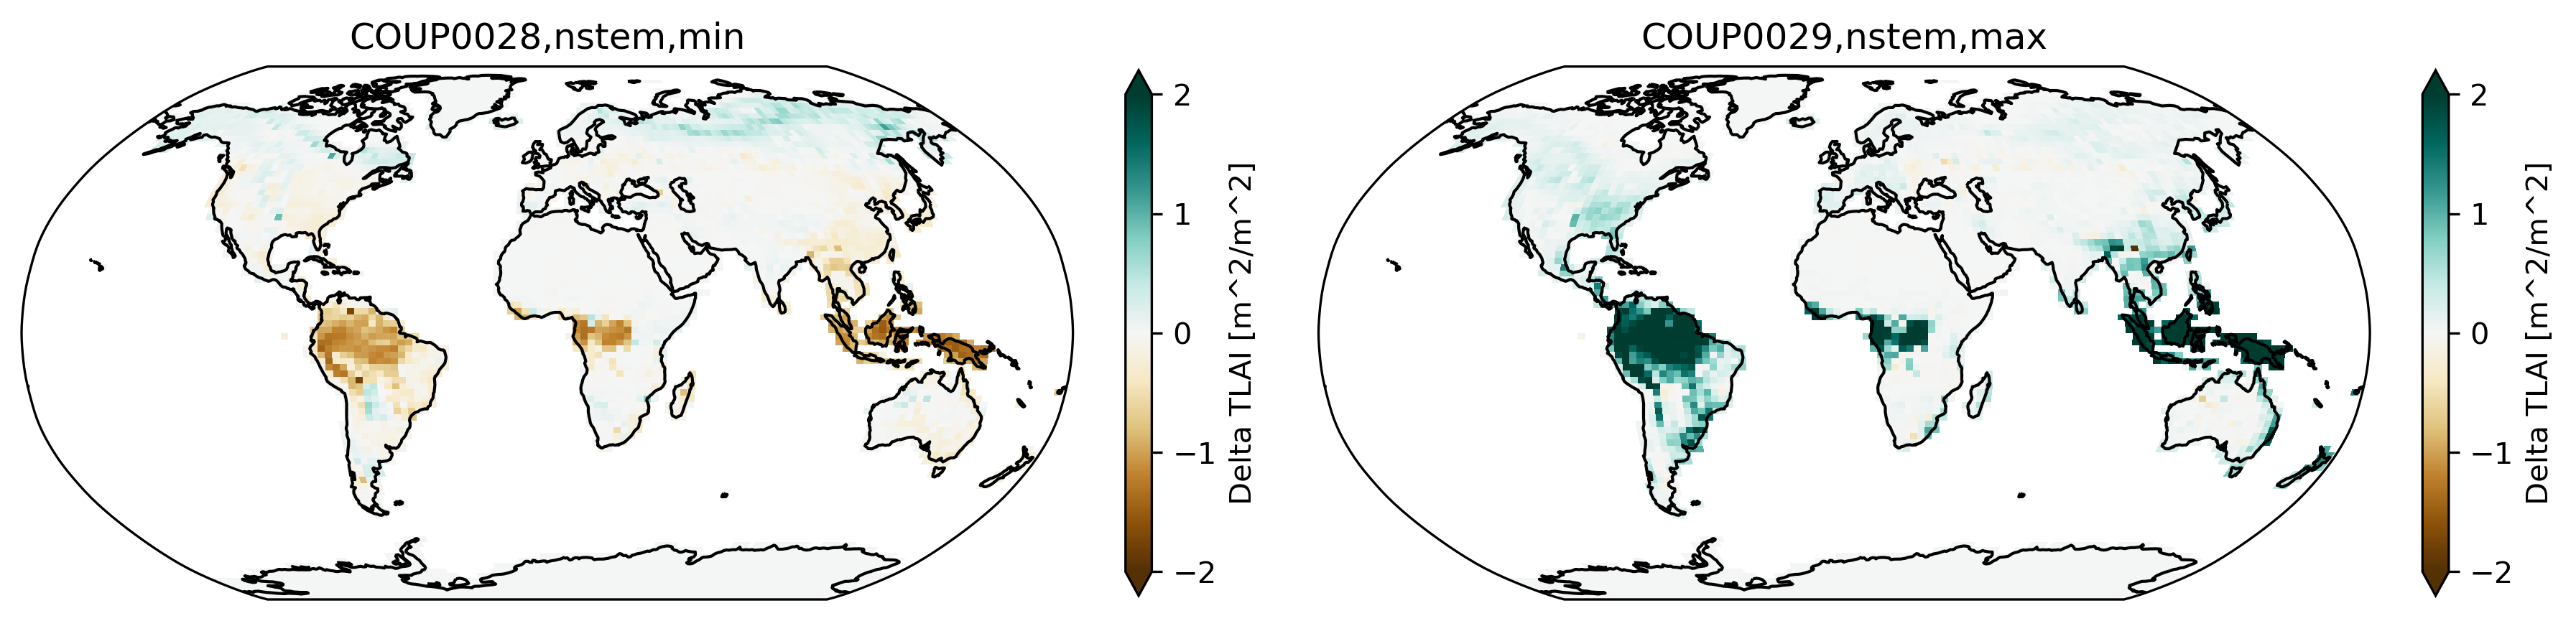

In [8]:
plot_map_minmax_param("nstem");

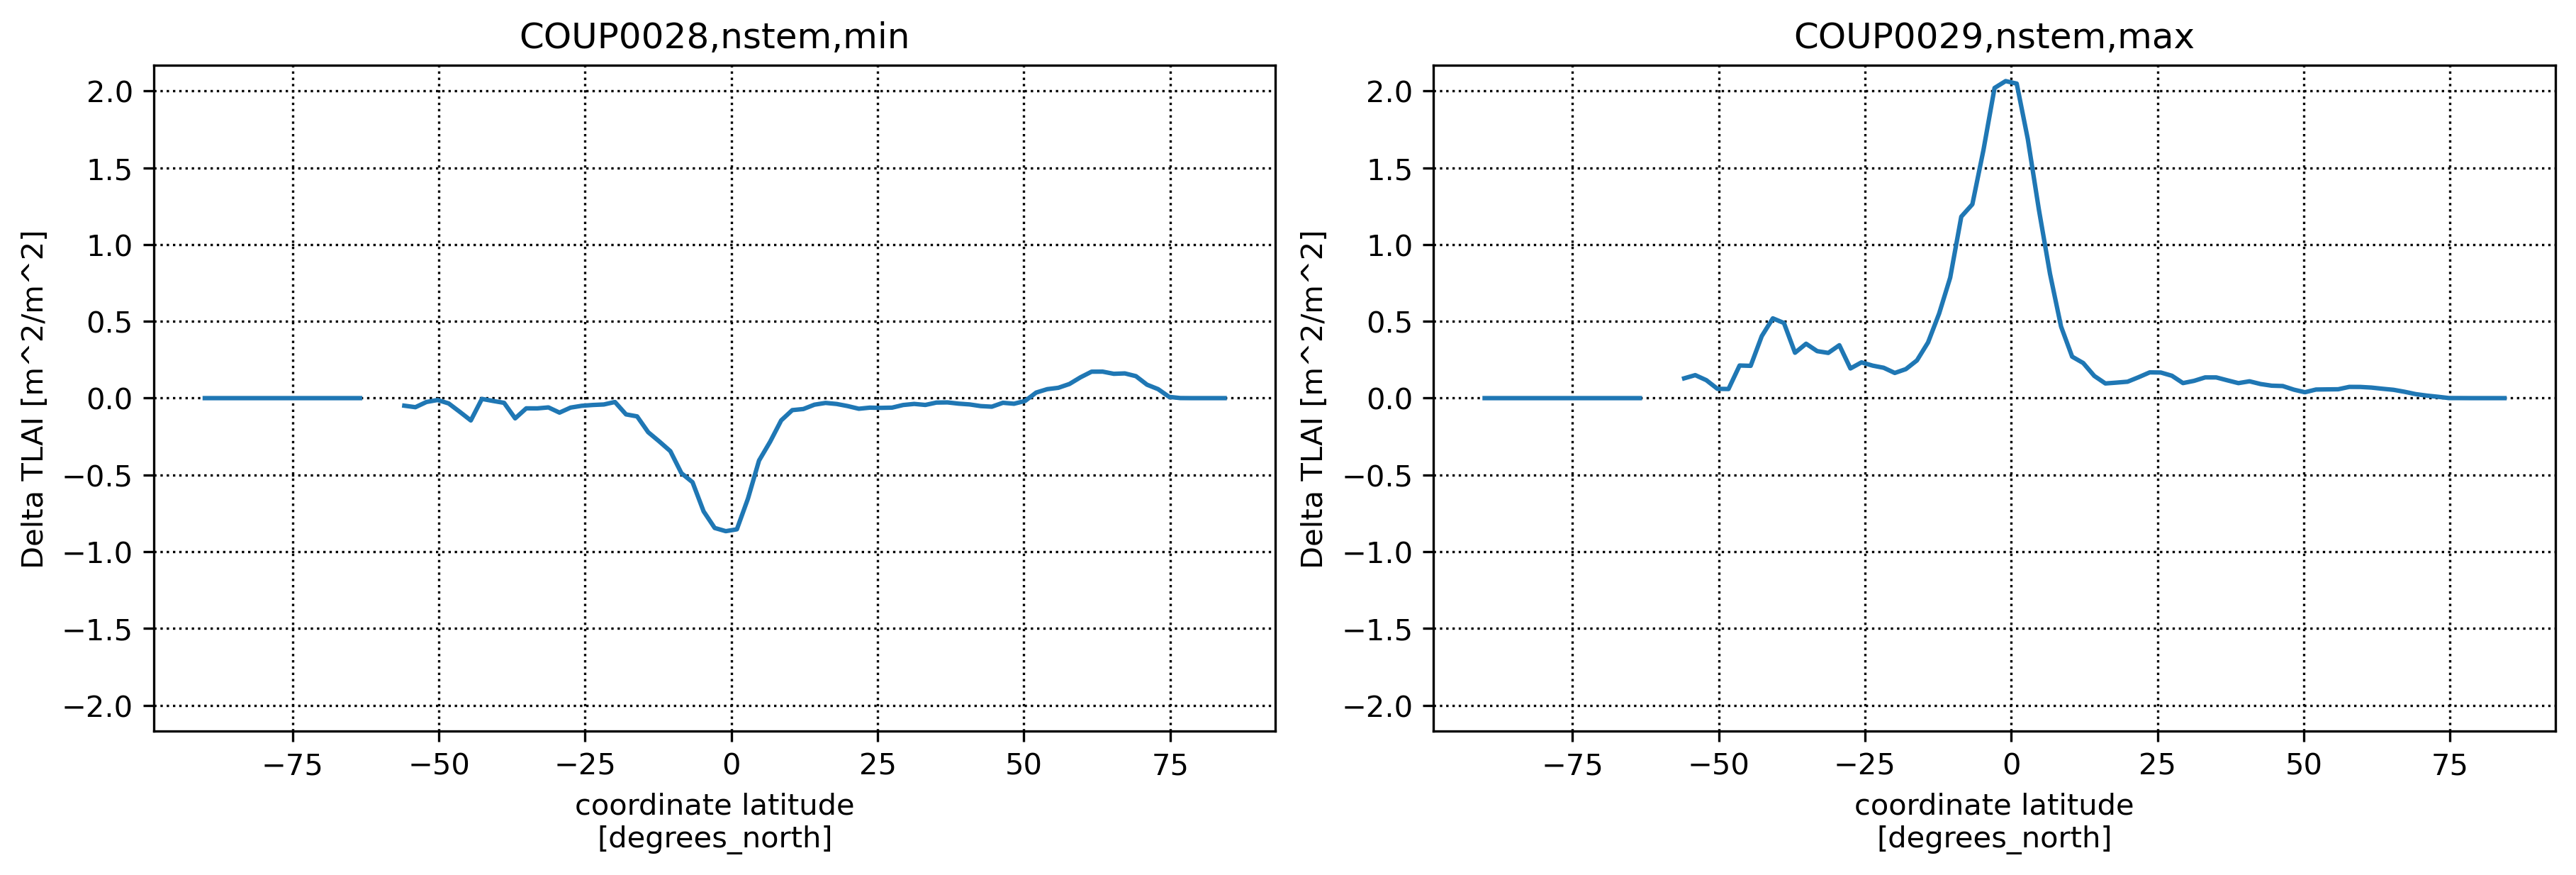

In [153]:
plot_zm_minmax_param("nstem");

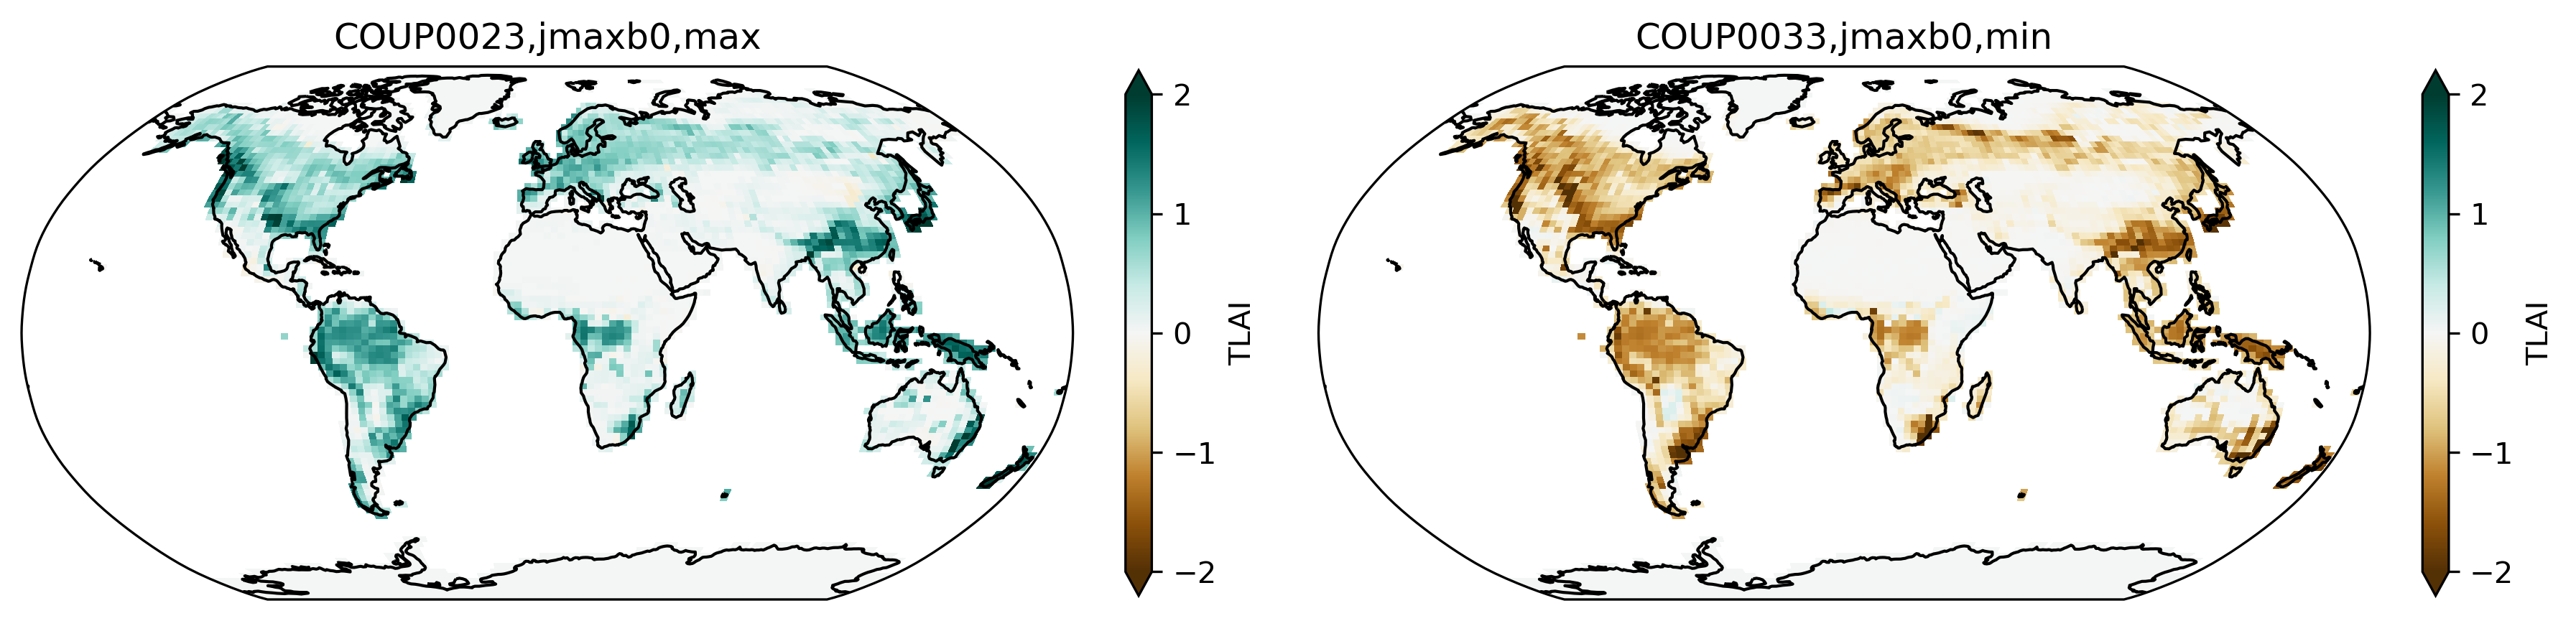

In [134]:
plot_map_minmax_param("jmaxb0");

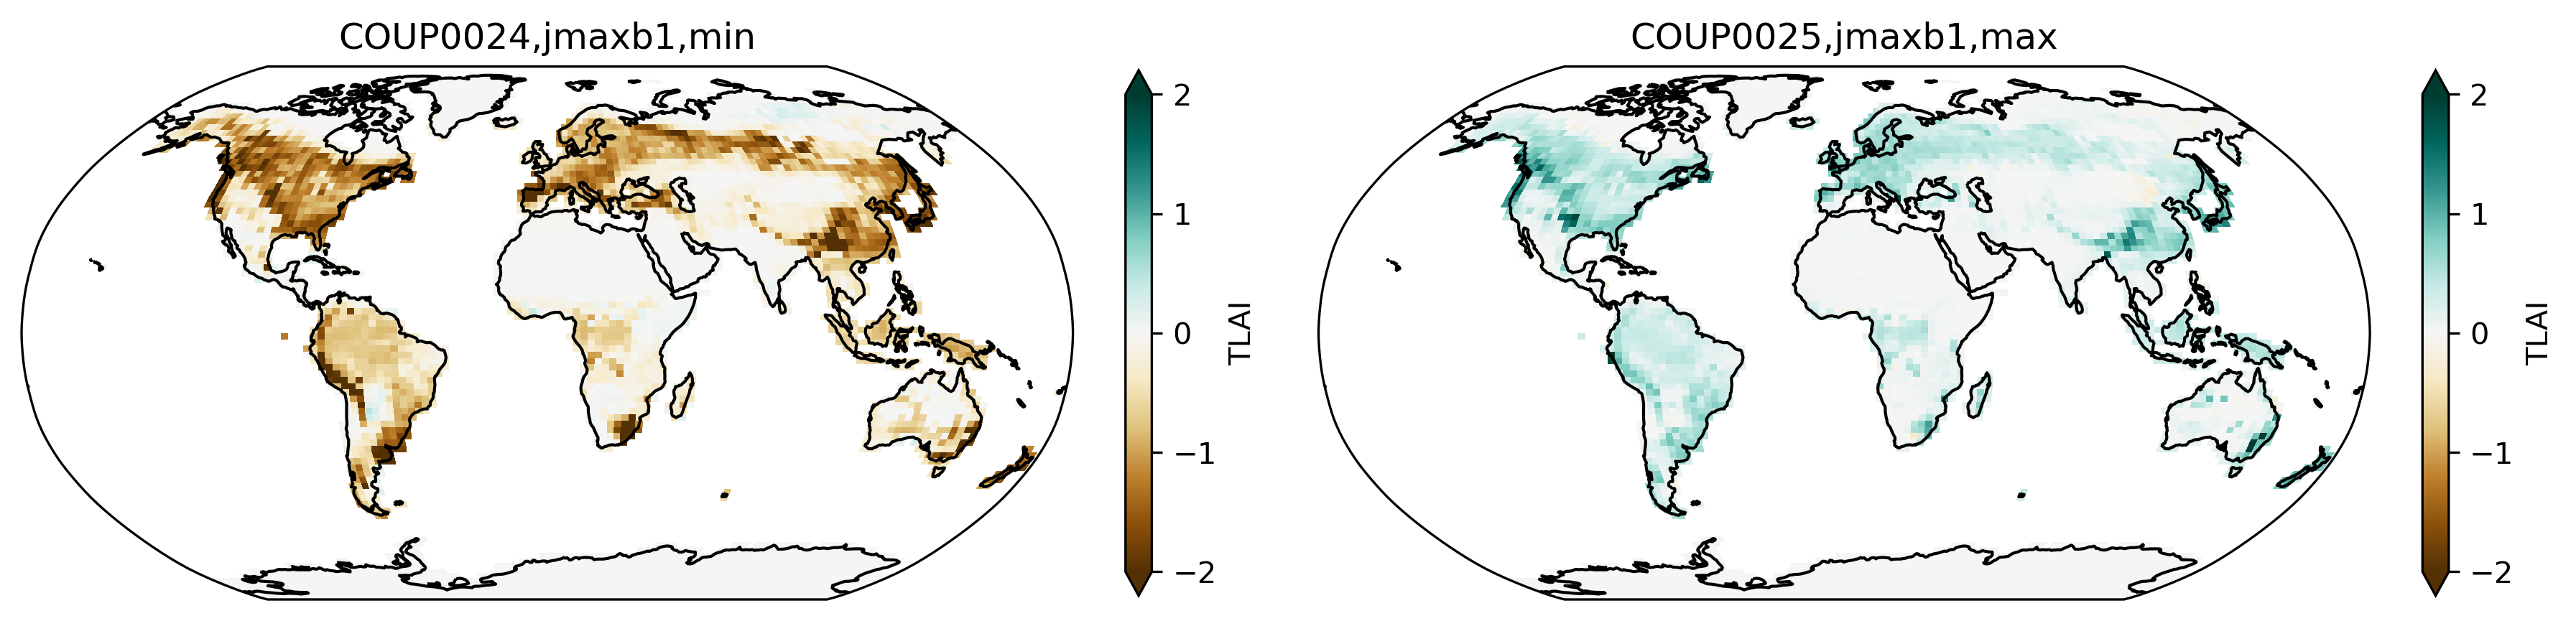

In [135]:
plot_map_minmax_param("jmaxb1");

In [7]:
comp = "atm"
v = "TREFHT"
var_cmip = xr.open_mfdataset(f"{cmip_dir}/{cmip_case}.001/atm/proc/tseries/month_1/*h0*.AREA.*.nc")["AREA"].isel(time=-1)
var_hist = xr.open_mfdataset(f"{hist_dir}/{hist_case}/{comp}/proc/tseries/month_1/*h0*.{v}.*.nc")[v].isel(time=-1)
var_piso = xr.open_mfdataset(f"{piso_dir}/{piso_case}/{comp}/proc/tseries/*h0*{v}.nc")[v].isel(time=-1)

print(f"Check that {comp} grids are equivalent:")
print(max(abs(var_cmip.lat.values - var_hist.lat.values)))
print(max(abs(var_cmip.lat.values - var_piso.lat.values)))
print(max(abs(var_hist.lat.values - var_piso.lat.values)))
print(max(abs(var_cmip.lon.values - var_hist.lon.values)))
print(max(abs(var_cmip.lon.values - var_piso.lon.values)))
print(max(abs(var_hist.lon.values - var_piso.lon.values)))


comp = "lnd"
v = "HTOP"
var_cmip = xr.open_mfdataset(f"{cmip_dir}/{cmip_case}.001/{comp}/proc/tseries/month_1/*h0*.{v}.*.nc")[v].isel(time=-1)
var_hist = xr.open_mfdataset(f"{hist_dir}/{hist_case}/{comp}/proc/tseries/month_1/*h0*.{v}.*.nc")[v].isel(time=-1)
var_piso = xr.open_mfdataset(f"{piso_dir}/{piso_case}/{comp}/proc/tseries/*h0*{v}.nc")[v].isel(time=-1)

print(f"Check that {comp} grids are equivalent:")
print(max(abs(var_cmip.lat.values - var_hist.lat.values)))
print(max(abs(var_cmip.lat.values - var_piso.lat.values)))
print(max(abs(var_hist.lat.values - var_piso.lat.values)))
print(max(abs(var_cmip.lon.values - var_hist.lon.values)))
print(max(abs(var_cmip.lon.values - var_piso.lon.values)))
print(max(abs(var_hist.lon.values - var_piso.lon.values)))

Check that atm grids are equivalent:
1.4210854715202004e-14
0.0
1.4210854715202004e-14
0.0
0.0
0.0
Check that lnd grids are equivalent:
0.0
0.0
0.0
0.0
0.0
0.0


In [9]:
def plot_tseries(da, tslice=slice(None, None), mask=None, weights=1.0, scale=1.0, annual=False, do_pool=False, ax=None, **kwargs):
    if mask is None:
        mask = xr.full_like(da, True, dtype=bool)
    else:
        if isinstance(weights, xr.DataArray) and ('lat' in weights.dims) and ('lon' in weights.dims) and (weights.sum() == 1):
            weights = weights.where(mask) / weights.where(mask).sum()
    
    # Recalculate weights if da is not global (e.g., just the tropics)
    if isinstance(weights, xr.DataArray) and (da.isel(time=0).shape != weights.shape) and not do_pool:
        weights = weights.where(da.isel(time=0)) / weights.where(da.isel(time=0)).sum()
        assert np.round(weights.sum(dim=["lat", "lon"]).values, 4) == 1
    
    if annual:
        if isinstance(weights, int) or isinstance(weights, float):
            (da * weights * scale).sel(time=tslice).where(mask).mean(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, **kwargs)

        elif isinstance(weights, xr.DataArray) and ('lat' in weights.dims) and ('lon' in weights.dims) and ((np.round(weights.sum(), 4) == 1) or do_pool):
            (da * weights * scale).sel(time=tslice).where(mask).sum(dim=["lat", "lon"]).groupby("time.year").mean(dim="time").plot(ax=ax, **kwargs)

    else:
        if isinstance(weights, int) or isinstance(weights, float):
            (da * weights * scale).sel(time=tslice).where(mask).mean(dim=["lat", "lon"]).plot(ax=ax, **kwargs)
            
        elif isinstance(weights, xr.DataArray) and ('lat' in weights.dims) and ('lon' in weights.dims) and ((np.round(weights.sum(), 4) == 1) or do_pool):
            (da * weights * scale).sel(time=tslice).where(mask).sum(dim=["lat", "lon"]).plot(ax=ax, **kwargs)


def plot_map(da, tslice=slice(None, None), mask=None, weights=1.0, ax=None, **kwargs):
    if mask is None:
        mask = xr.full_like(da, True, dtype=bool)
    
    (da * weights).sel(time=tslice).where(mask).mean(dim="time").plot(ax=ax, **kwargs)


def compare_ann_tseries(var, lat=[-90, 90], land_only=False, do_pool=False, **kwargs):
    if var in variables["atm"]:
        if land_only:
            weights = "landweights"
        else:
            weights = "areaweights"
    elif var in variables["lnd"]:
        weights = "landweights"
    else:
        raise ValueError()

    scale = 1.0
    if do_pool:
        weights = "landarea"
        scale = 1e6
    
    do_piso = 1

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
    plot_tseries(hist[var].sel(lat=slice(lat[0], lat[1])), annual=True, weights=hist[weights], do_pool=do_pool, scale=scale, ax=ax[0], label="HIST", color="tab:blue", **kwargs)
    for i in range(3):
        plot_tseries(cmip[var][i].sel(lat=slice(lat[0], lat[1])), annual=True, weights=cmip[weights], do_pool=do_pool, scale=scale, ax=ax[0], label=f"ENS{i+1}", color="tab:orange", **kwargs)
    try:
        plot_tseries(piso[var].sel(lat=slice(lat[0], lat[1])), weights=piso[weights], do_pool=do_pool, annual=True, scale=scale, ax=ax[1], label="PISO", color="tab:green", **kwargs)
    except KeyError:
        print(f"{var} timeseries not avail for PISO")
        do_piso = 0

    # Find the min and max y-limits values across the two axes for consistent y-limits
    ymins = [a.get_ylim()[0] for a in ax]
    ymaxs = [a.get_ylim()[1] for a in ax]
    min_ylim = min(ymins)
    max_ylim = max(ymaxs)

    min_ylim = min_ylim - 0.1 * (max_ylim - min_ylim)
    max_ylim = max_ylim + 0.1 * (max_ylim - min_ylim)

    for a in ax[0:(1+do_piso)]:
        a.legend()
        a.set_ylim(min_ylim, max_ylim)
        a.set_ylabel(f"{var} [{hist[var].units}]")
        a.grid(lw=0.8, ls=":")

    if do_pool:
        fig.suptitle(f"total sum of {var}, {weights} [ ${lat[0]}$N, ${lat[1]}$N ]")
    else:
        fig.suptitle(f"area-weighted average of {var}, {weights} [ ${lat[0]}$N, ${lat[1]}$N ]")
    
    return fig, ax


def compare_maps(var, lat=[-90, 90], land_only=False, **kwargs):
    fig, axs = plt.subplots(2, 3, figsize=(15, 6), layout="constrained")
    ax = axs.flatten()

    do_piso = 1
    tslice_hist_cmip = slice("1990-01", "2009-12")

    if land_only:
        mask = ~np.isnan(hist["landweights"].sel(lat=slice(lat[0], lat[1])))
    else:
        mask = None

    plot_map(hist[var].sel(lat=slice(lat[0], lat[1])), tslice=tslice_hist_cmip, mask=mask, ax=ax[3], **kwargs)
    for i in range(3):
        plot_map(cmip[var][i].sel(lat=slice(lat[0], lat[1])), mask=mask, ax=ax[i], **kwargs)
    try:
        plot_map(piso[var].sel(lat=slice(lat[0], lat[1])), mask=mask, ax=ax[4], **kwargs)
    except KeyError:
        print(f"{var} timeseries not avail for PISO")
        do_piso = 0


    # Find the min and max values across all plotted maps for consistent colorbars
    vmins = []
    vmaxs = []
    for i in range(4 + do_piso):
        im = ax[i].collections[0]
        vmins.append(im.get_clim()[0])
        vmaxs.append(im.get_clim()[1])
    vmin = min(vmins)
    vmax = max(vmaxs)
    for i in range(4 + do_piso):
        im = ax[i].collections[0]
        im.set_clim(vmin, vmax)

    ax[3].set_title("HIST " + str(tslice_hist_cmip))
    ax[0].set_title("ENS1 " + str(tslice_hist_cmip))
    ax[1].set_title("ENS2 " + str(tslice_hist_cmip))
    ax[2].set_title("ENS3 " + str(tslice_hist_cmip))
    if do_piso:
        ax[4].set_title("PISO " + str(slice("0100-01", "0188-12")))
    ax[5].remove()

    return fig, ax

# Time series

In [16]:
case = "f.e21.FHIST_BGC.f19_f19_mg17.CMIP6-AMIP-2deg-3year-srcmod"
indir = f"/glade/derecho/scratch/bbuchovecky/archive/{case}"

cmip_derecho = dict()

start_year = 1950
end_year = 1952
times = np.array([cftime.DatetimeNoLeap(year, month, 1)
                  for year in range(start_year, end_year + 1)
                  for month in range(1, 13)])

for comp, vars in variables.items():
    for v in vars:

        cmip_derecho[v] = xr.open_mfdataset(f"{indir}/{comp}/hist/{case}.*.h0.*.nc")[v]

        cmip_derecho[v] = cmip_derecho[v].assign_coords(time=times)
        cmip_derecho[v] = cmip_derecho[v].reindex_like(hist[variables["atm"][0]].sel(time=slice("1950-01", "1952-12")), method="nearest", tolerance=1e-3)

/glade/derecho/scratch/bbuchovecky/tmp/ipykernel_65828/3722925271.py:15: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  cmip_derecho[v] = xr.open_mfdataset(f"{indir}/{comp}/hist/{case}.*.h0.*.nc")[v]
/glade/derecho/scratch/bbuchovecky/tmp/ipykernel_65828/3722925271.py:15: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  cmip_derecho[v] = xr.open_mfdataset(f"{indir}/{comp}/hist/{case}.*.h0.*.nc")[v]
/glade/derecho/scratch/bbuchovecky/tmp/ipykernel_65828/3722925271.py:15: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  cmip_derecho[v] = xr.

Text(0, 0.5, 'TLAI [m^2/m^2]')

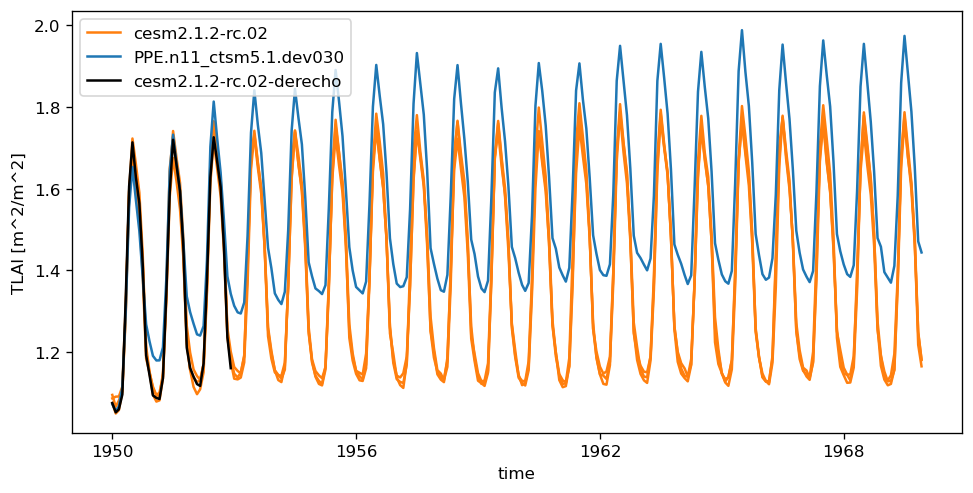

In [11]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")

tslice = slice("1950-01", "1969-12")

for i in range(3):
    label = None
    if i == 0:
        label = "cesm2.1.2-rc.02"

    plot_tseries(
        cmip["TLAI"][i], tslice=tslice,
        mask=None, weights=cmip["landweights"], scale=1.0,
        annual=False, do_pool=False,
        ax=ax, color="tab:orange", label=label)

plot_tseries(
    hist["TLAI"], tslice=tslice,
    mask=None, weights=hist["landweights"], scale=1.0,
    annual=False, do_pool=False,
    ax=ax, color="tab:blue", label="PPE.n11_ctsm5.1.dev030")

plot_tseries(
    cmip_derecho["TLAI"], tslice=tslice,
    mask=None, weights=hist["landweights"], scale=1.0,
    annual=False, do_pool=False,
    ax=ax, color="k", label="cesm2.1.2-rc.02-derecho")

ax.legend()
ax.set_ylabel("TLAI [m^2/m^2]")

Text(0, 0.5, 'TLAI [m^2/m^2]')

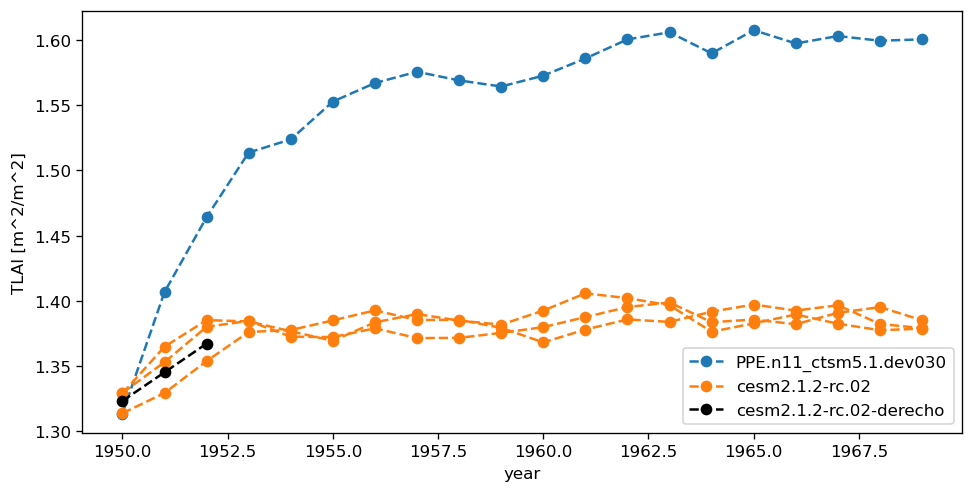

In [12]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")

tslice = slice("1950-01", "1969-12")

plot_tseries(
    hist["TLAI"], tslice=tslice,
    mask=None, weights=hist["landweights"], scale=1.0,
    annual=True, do_pool=False,
    ax=ax, color="tab:blue", ls="--", marker="o", label="PPE.n11_ctsm5.1.dev030")

for i in range(3):
    label = None
    if i == 0:
        label = "cesm2.1.2-rc.02"

    plot_tseries(
        cmip["TLAI"][i], tslice=tslice,
        mask=None, weights=cmip["landweights"], scale=1.0,
        annual=True, do_pool=False,
        ax=ax, color="tab:orange", ls="--", marker="o", label=label)

plot_tseries(
    cmip_derecho["TLAI"], tslice=tslice,
    mask=None, weights=hist["landweights"], scale=1.0,
    annual=True, do_pool=False,
    ax=ax, color="k", ls="--", marker="o", label="cesm2.1.2-rc.02-derecho")

ax.legend()
ax.set_ylabel("TLAI [m^2/m^2]")

Text(0, 0.5, 'LHFLX')

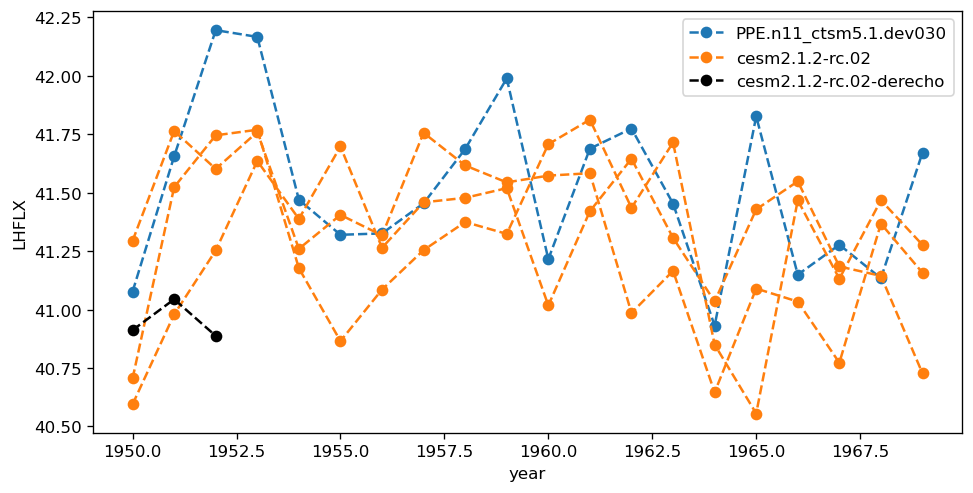

In [21]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")

var = "LHFLX"
tslice = slice("1950-01", "1969-12")

plot_tseries(
    hist[var], tslice=tslice,
    mask=None, weights=hist["landweights"], scale=1.0,
    annual=True, do_pool=False,
    ax=ax, color="tab:blue", ls="--", marker="o", label="PPE.n11_ctsm5.1.dev030")

for i in range(3):
    label = None
    if i == 0:
        label = "cesm2.1.2-rc.02"

    plot_tseries(
        cmip[var][i], tslice=tslice,
        mask=None, weights=cmip["landweights"], scale=1.0,
        annual=True, do_pool=False,
        ax=ax, color="tab:orange", ls="--", marker="o", label=label)

plot_tseries(
    cmip_derecho[var], tslice=tslice,
    mask=None, weights=hist["landweights"], scale=1.0,
    annual=True, do_pool=False,
    ax=ax, color="k", ls="--", marker="o", label="cesm2.1.2-rc.02-derecho")

ax.legend()
ax.set_ylabel(f"{var}")

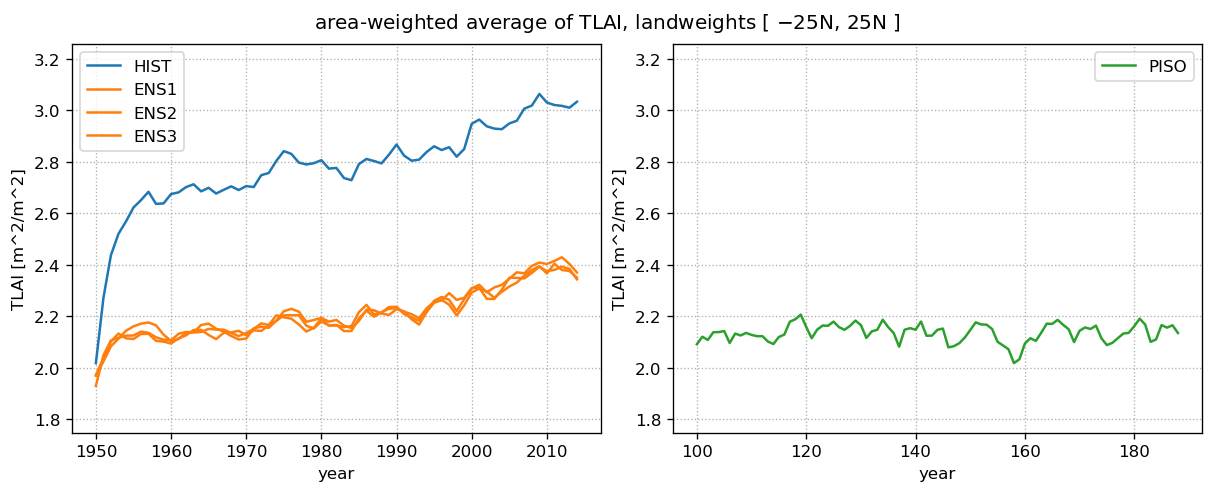

In [53]:
compare_ann_tseries("TLAI", [-25, 25]);

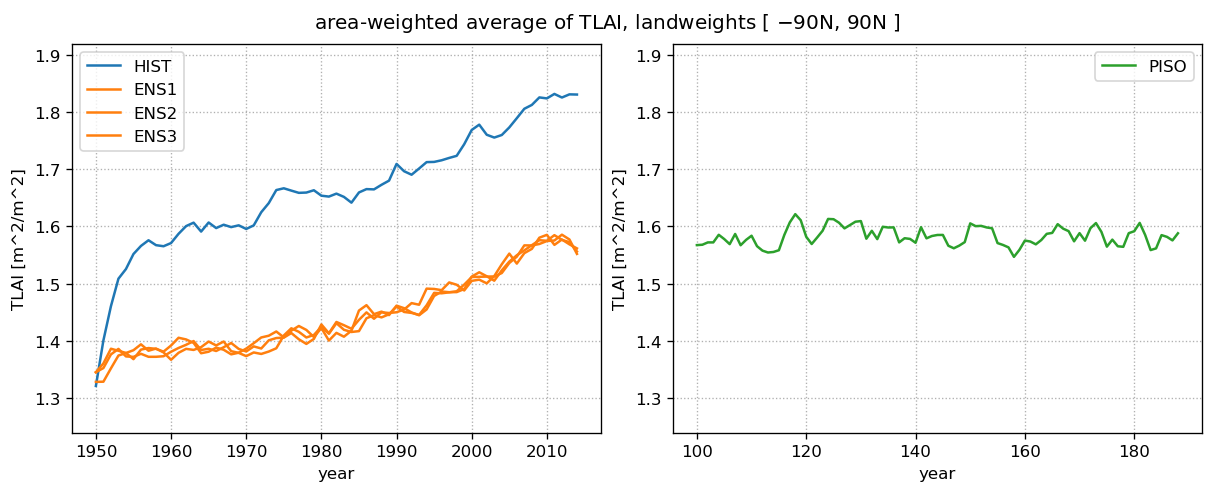

In [55]:
compare_ann_tseries("TLAI", [-90, 90]);

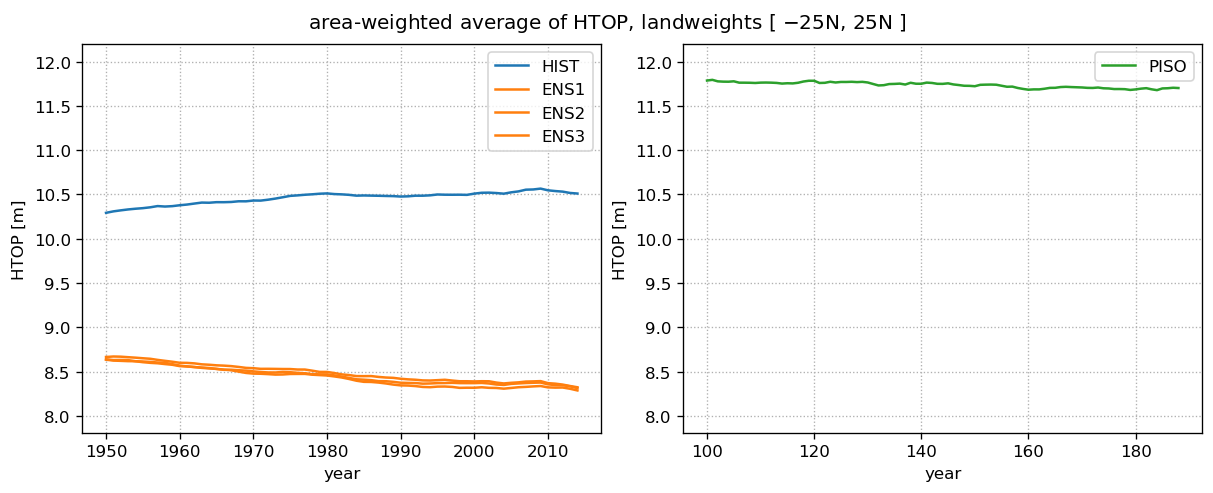

In [56]:
compare_ann_tseries("HTOP", [-25, 25]);

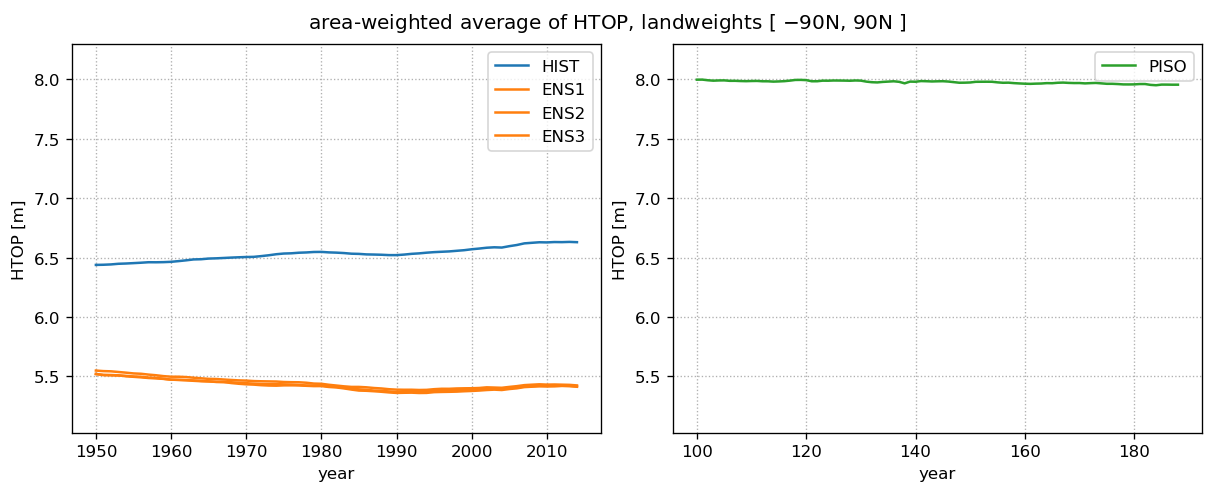

In [57]:
compare_ann_tseries("HTOP", [-90, 90]);

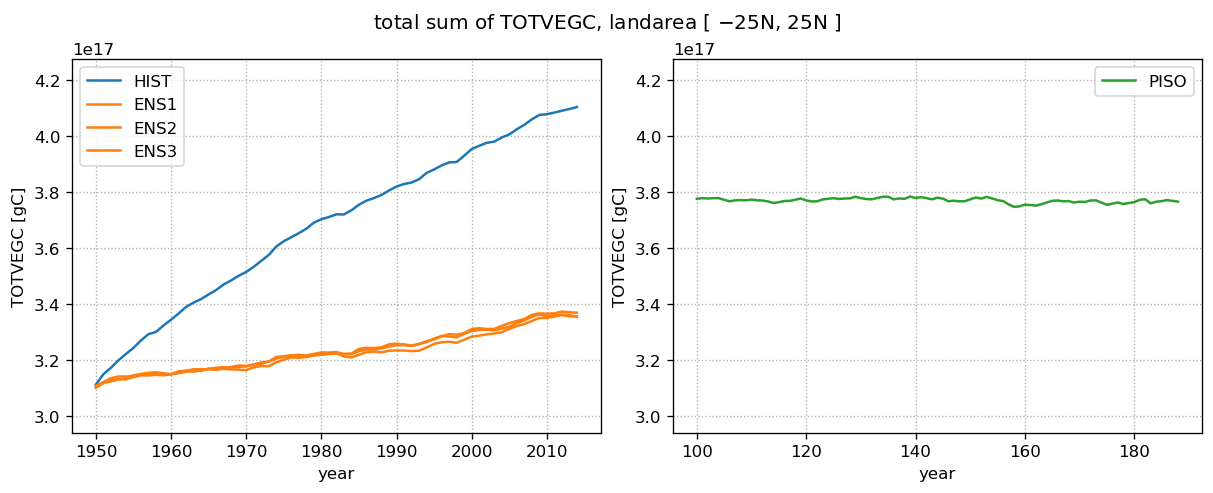

In [58]:
fig, ax = compare_ann_tseries("TOTVEGC", [-25, 25], do_pool=True);
for a in ax:
    a.set_ylabel("TOTVEGC [gC]")

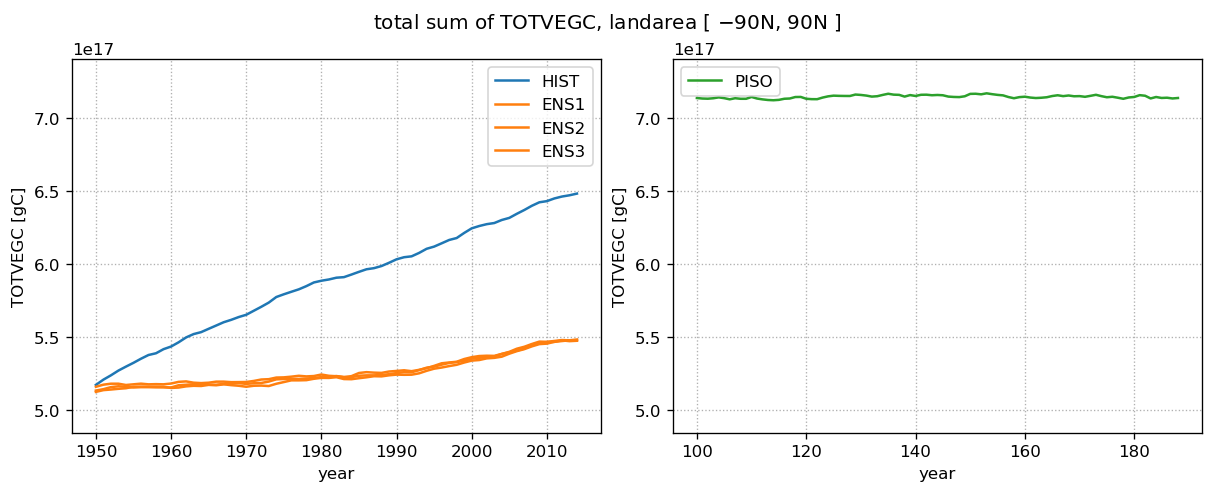

In [59]:
fig, ax = compare_ann_tseries("TOTVEGC", [-90, 90], do_pool=True);
for a in ax:
    a.set_ylabel("TOTVEGC [gC]")

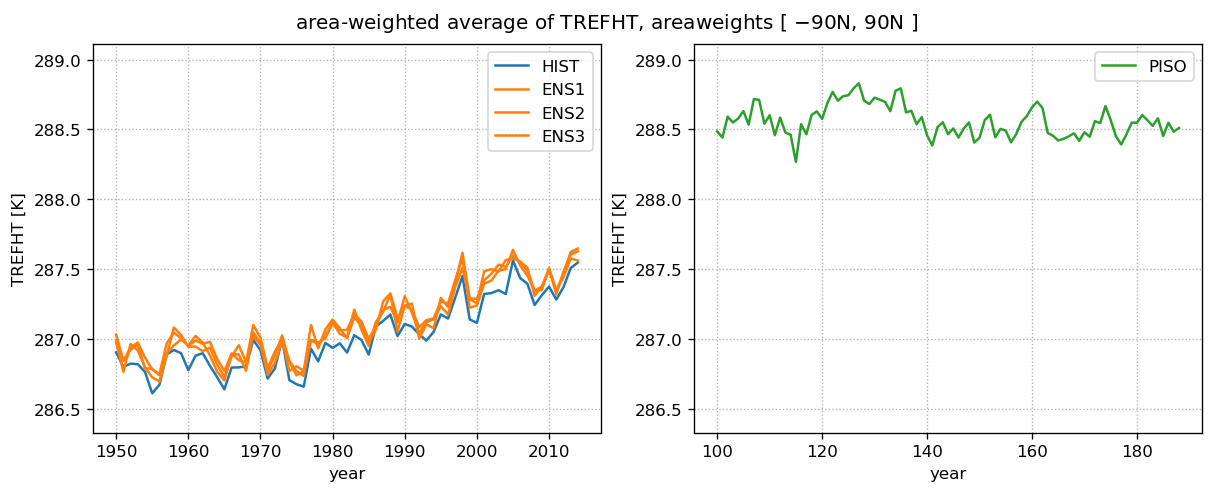

In [72]:
compare_ann_tseries("TREFHT", [-90, 90], land_only=False);

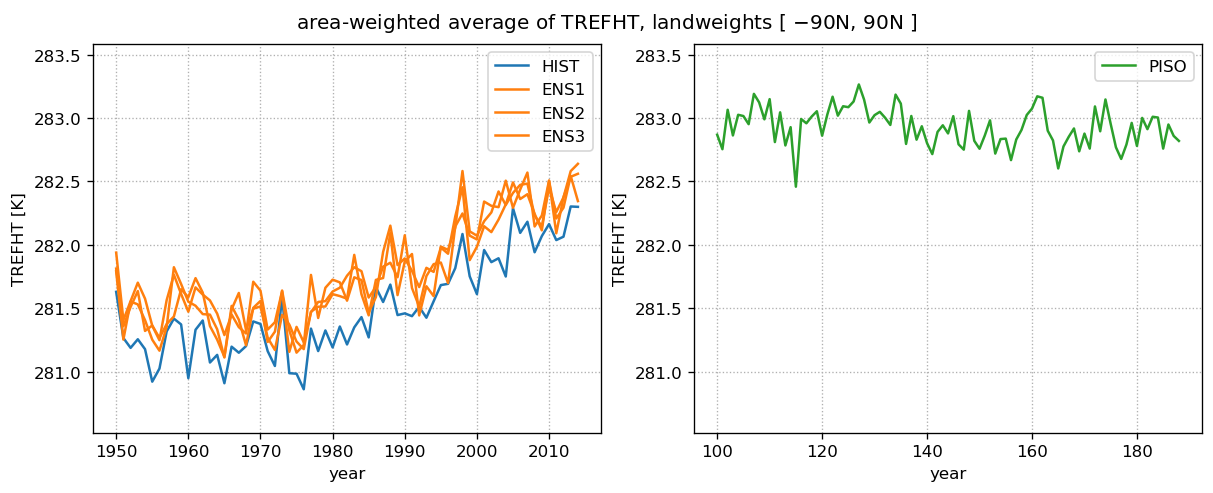

In [73]:
compare_ann_tseries("TREFHT", [-90, 90], land_only=True);

# Maps

HR timeseries not avail for PISO


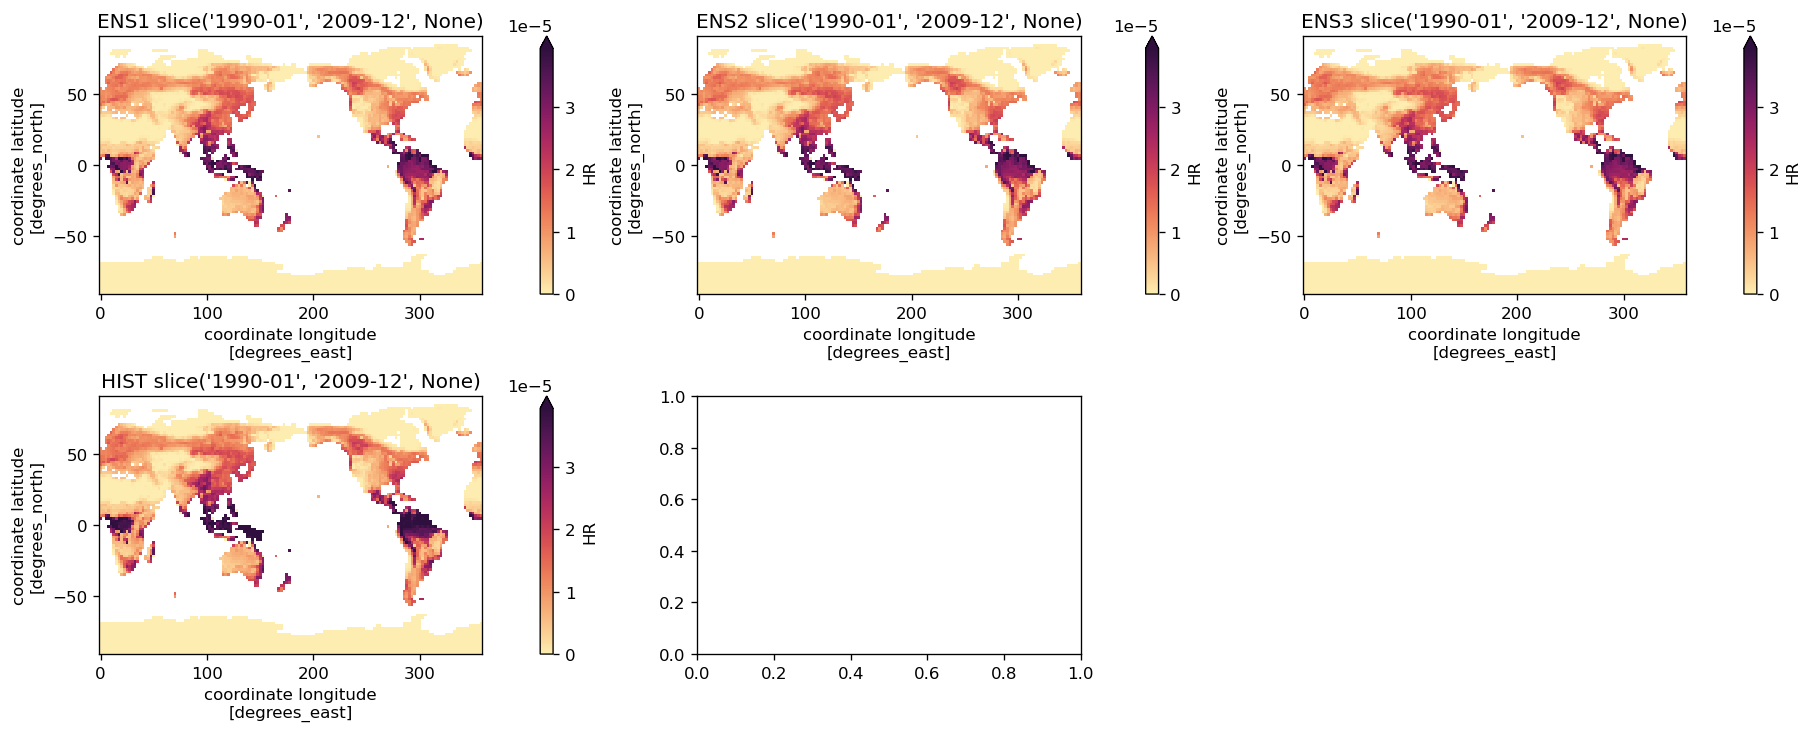

In [ ]:
compare_maps("HR", cmap=cmo.matter, robust=True);

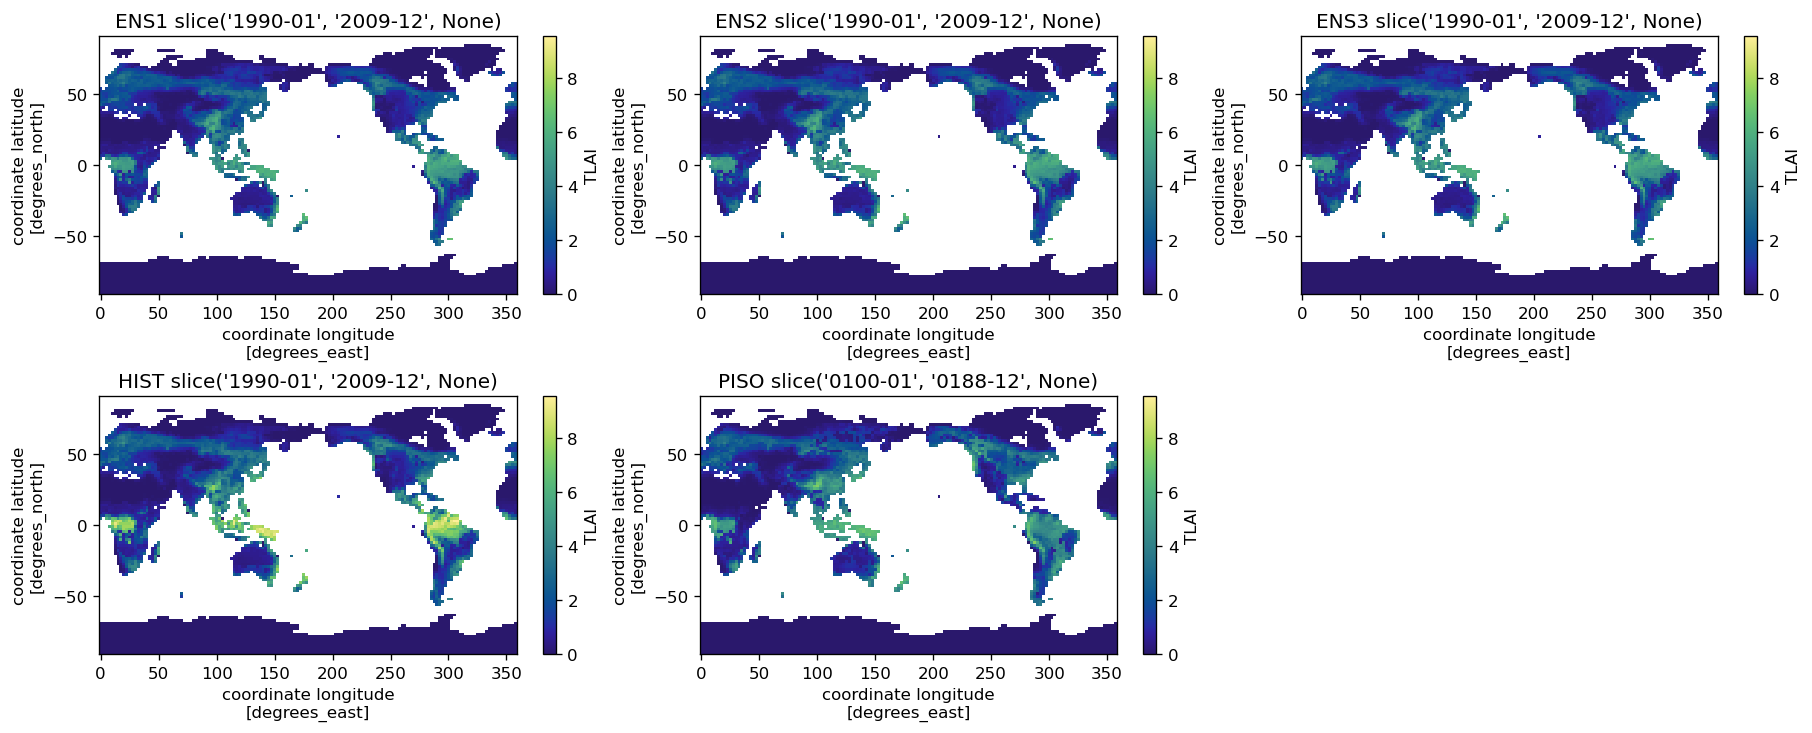

In [ ]:
compare_maps("TLAI", cmap=cmo.haline);

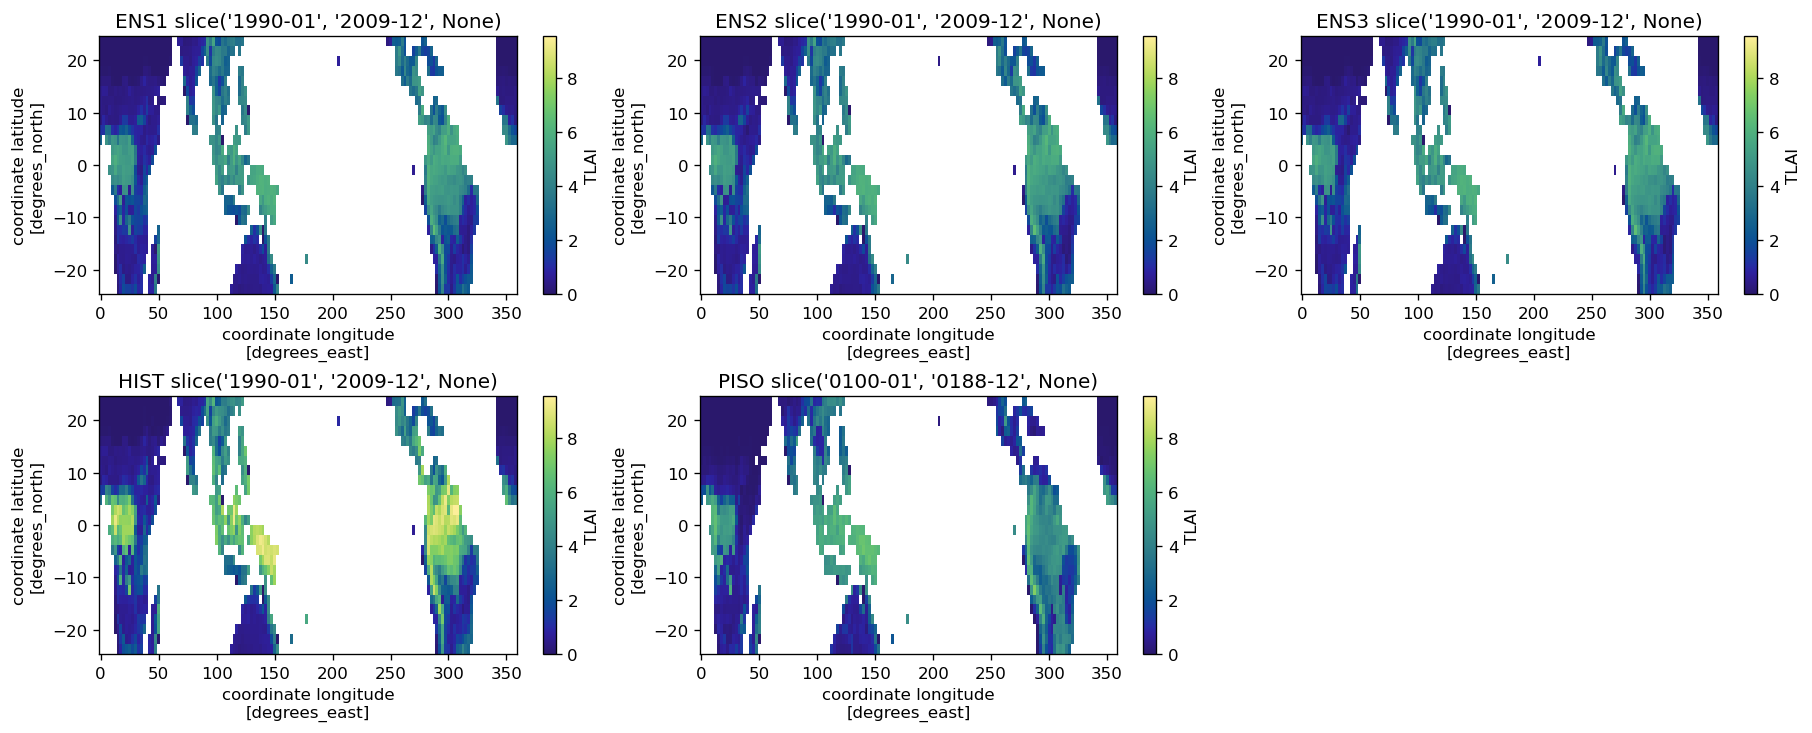

In [ ]:
compare_maps("TLAI", lat=[-25, 25], cmap=cmo.haline);

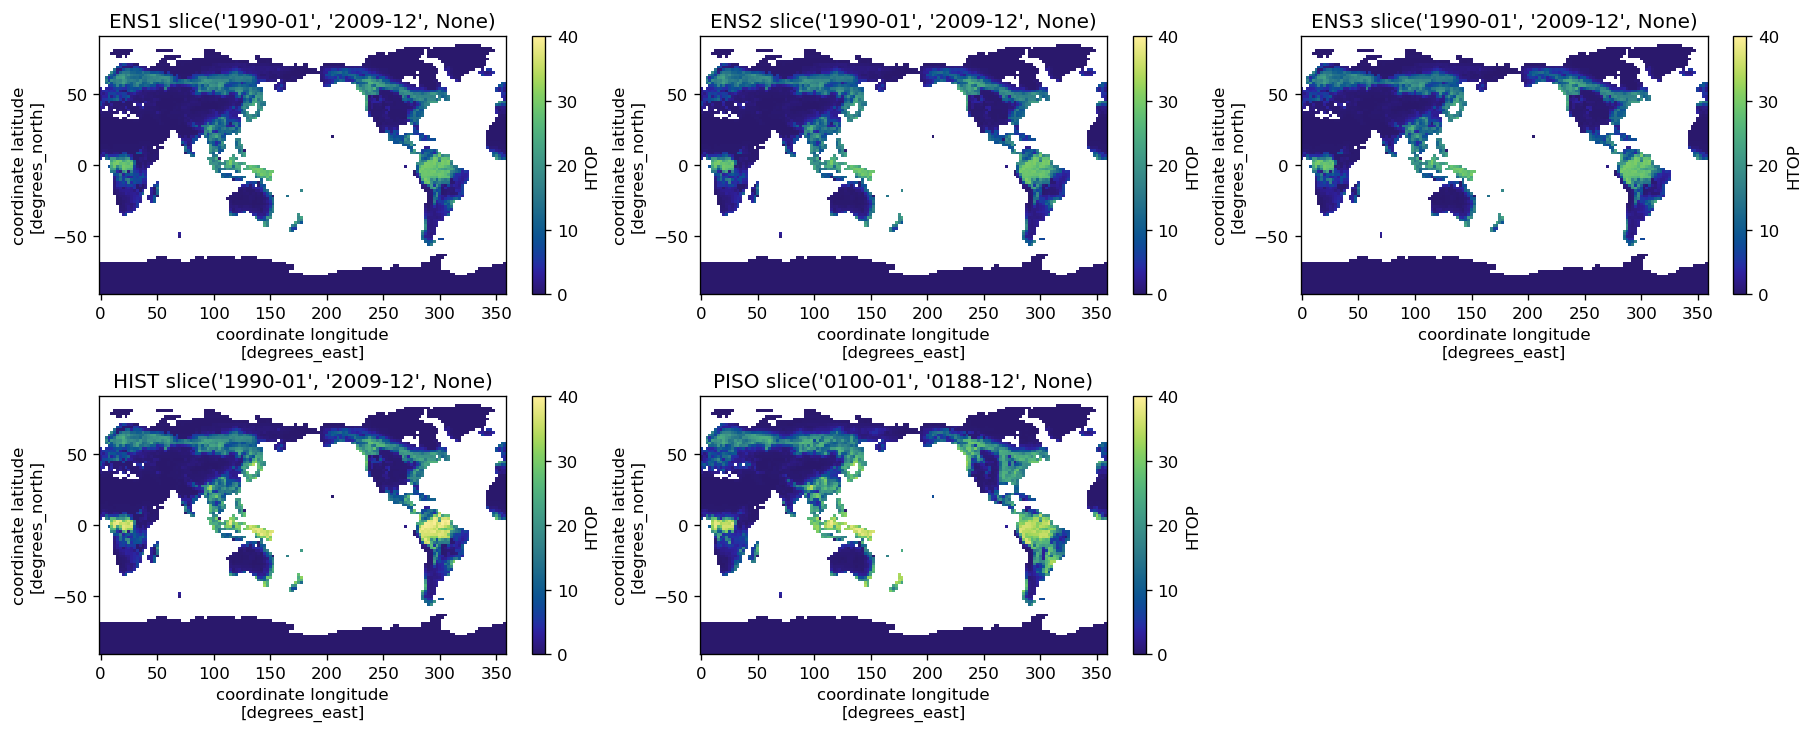

In [ ]:
compare_maps("HTOP", cmap=cmo.haline);

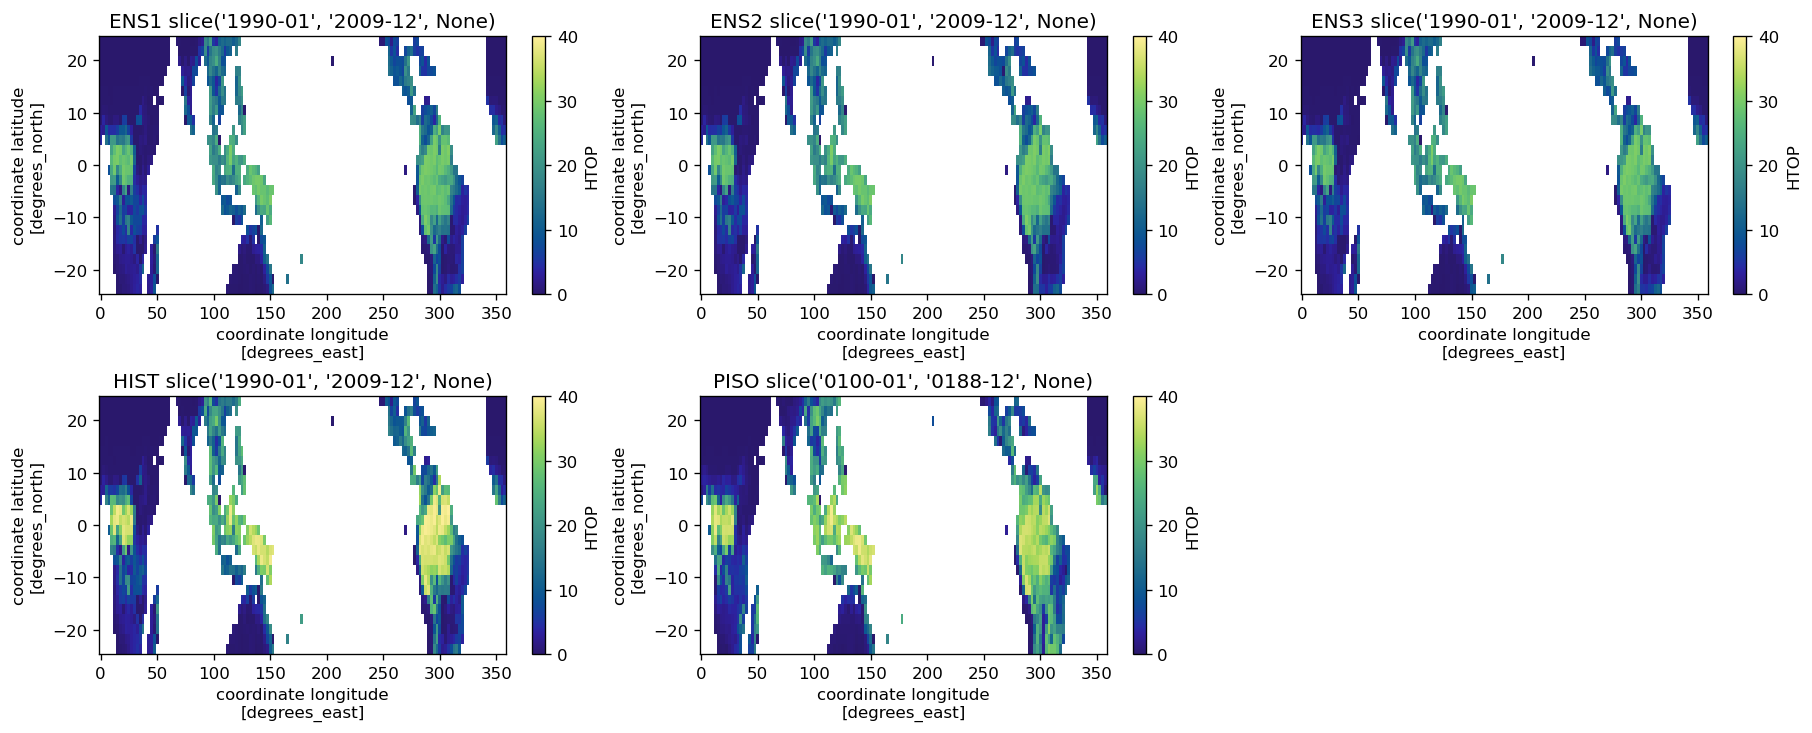

In [ ]:
compare_maps("HTOP", lat=[-25, 25], cmap=cmo.haline);

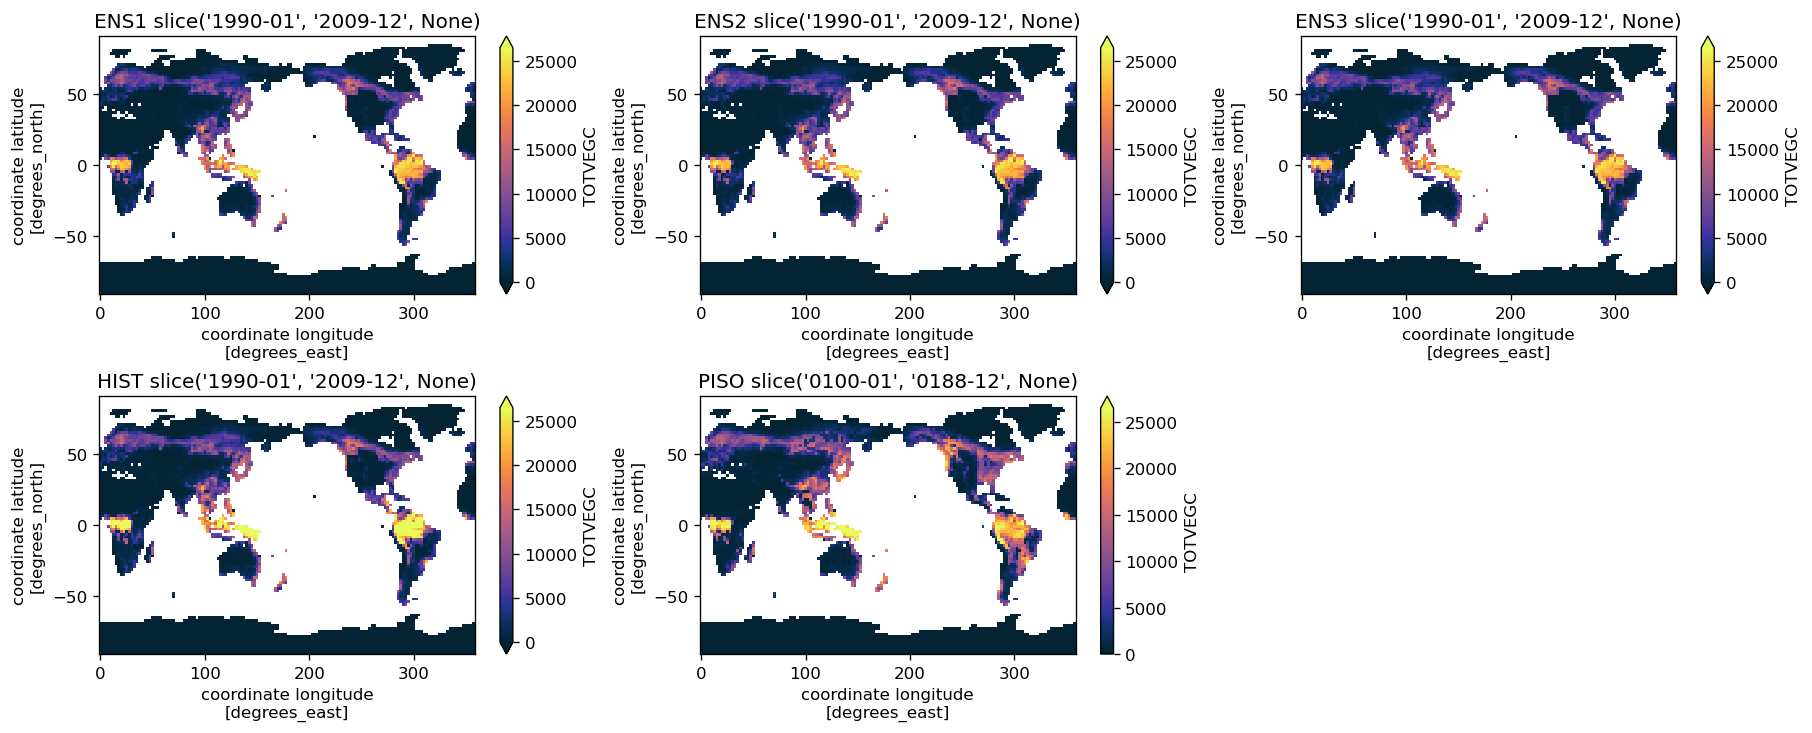

In [ ]:
fig, ax = compare_maps("TOTVEGC", cmap=cmo.thermal, vmin=0, robust=True)

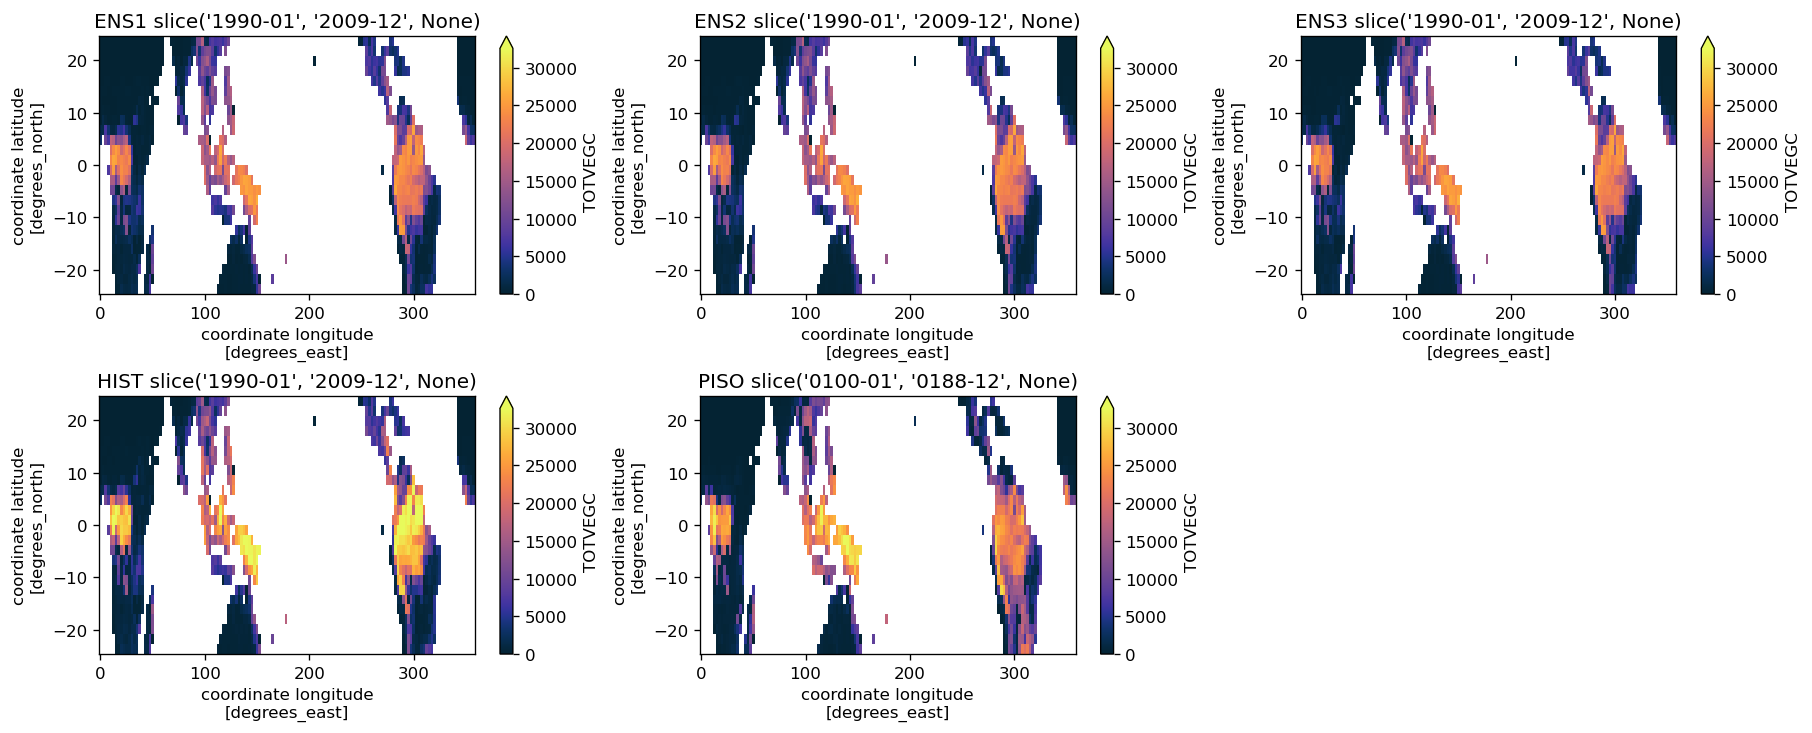

In [ ]:
fig, ax = compare_maps("TOTVEGC", lat=[-25, 25], cmap=cmo.thermal, vmin=0, robust=True)

TOTSOMC timeseries not avail for PISO


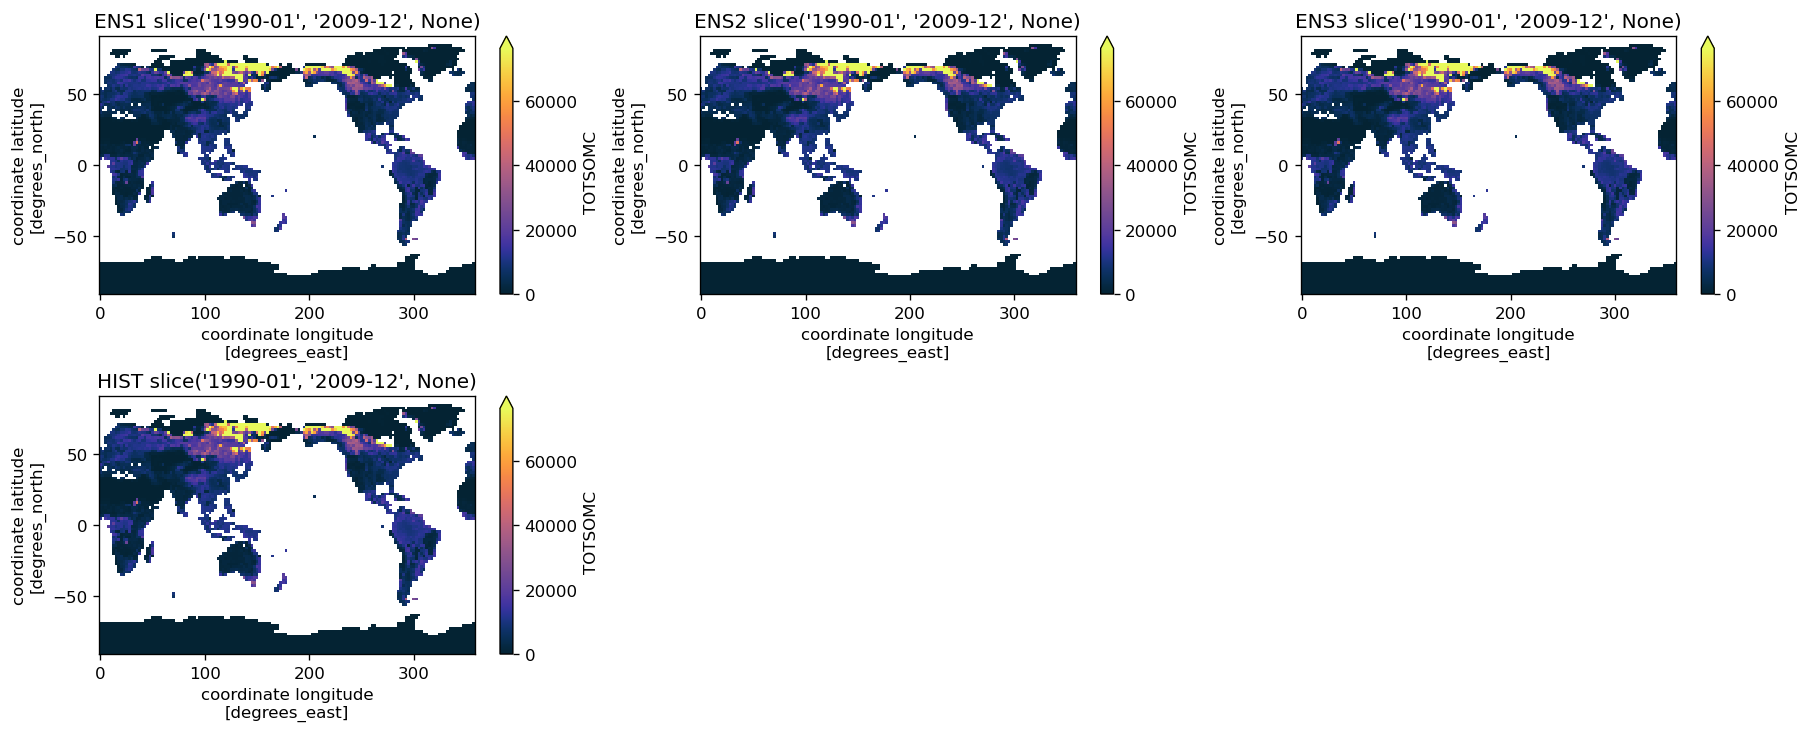

In [ ]:
fig, ax = compare_maps("TOTSOMC", cmap=cmo.thermal, vmin=0, robust=True)
ax[4].remove()

TOTLITC timeseries not avail for PISO


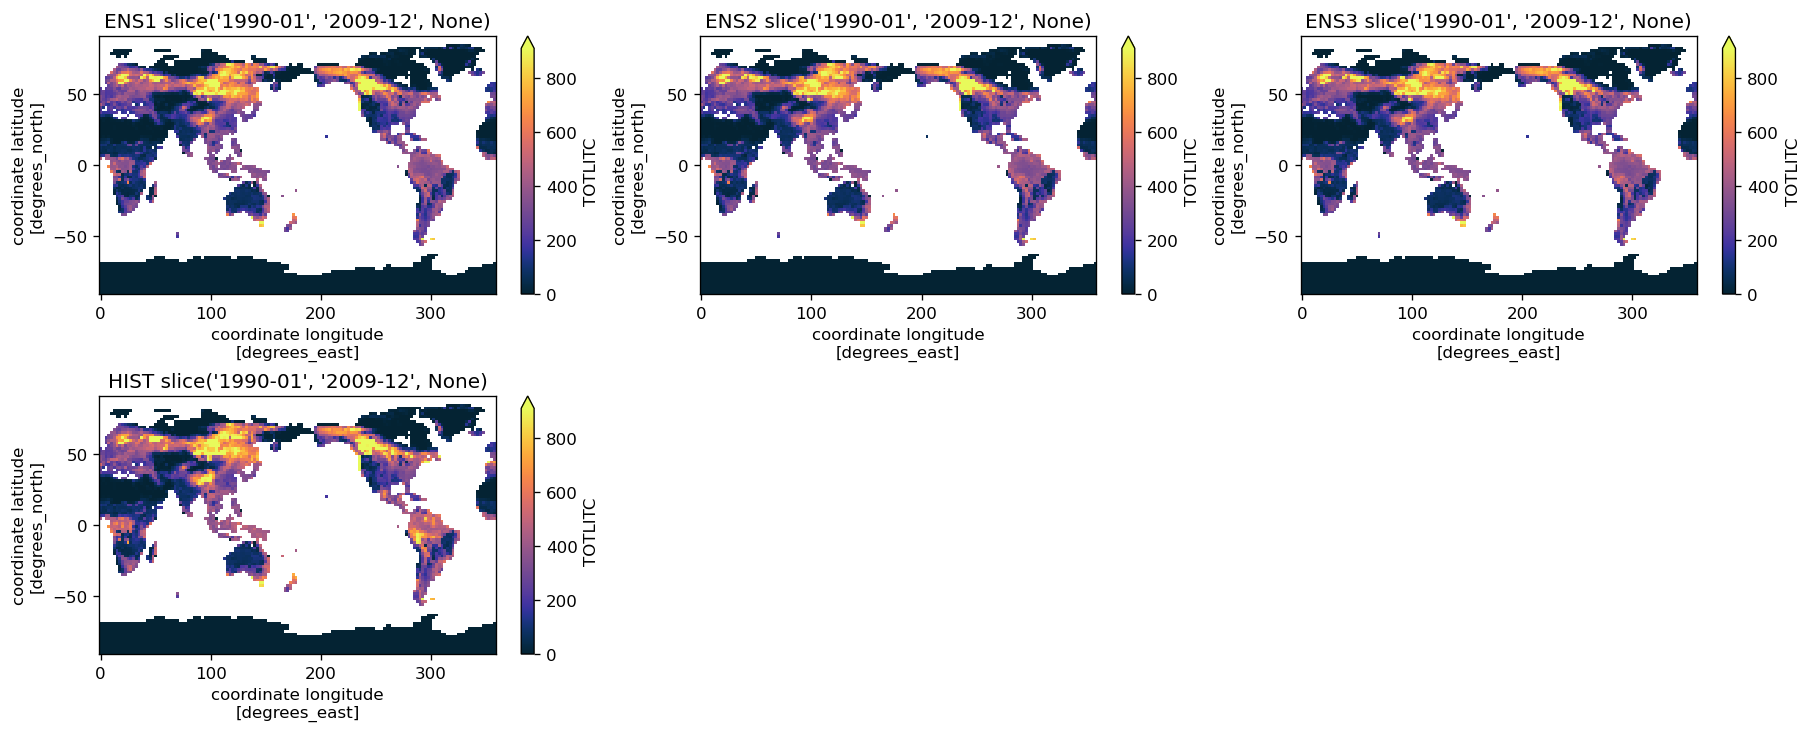

In [ ]:
fig, ax = compare_maps("TOTLITC", cmap=cmo.thermal, vmin=0, robust=True)
ax[4].remove()

CWDC timeseries not avail for PISO


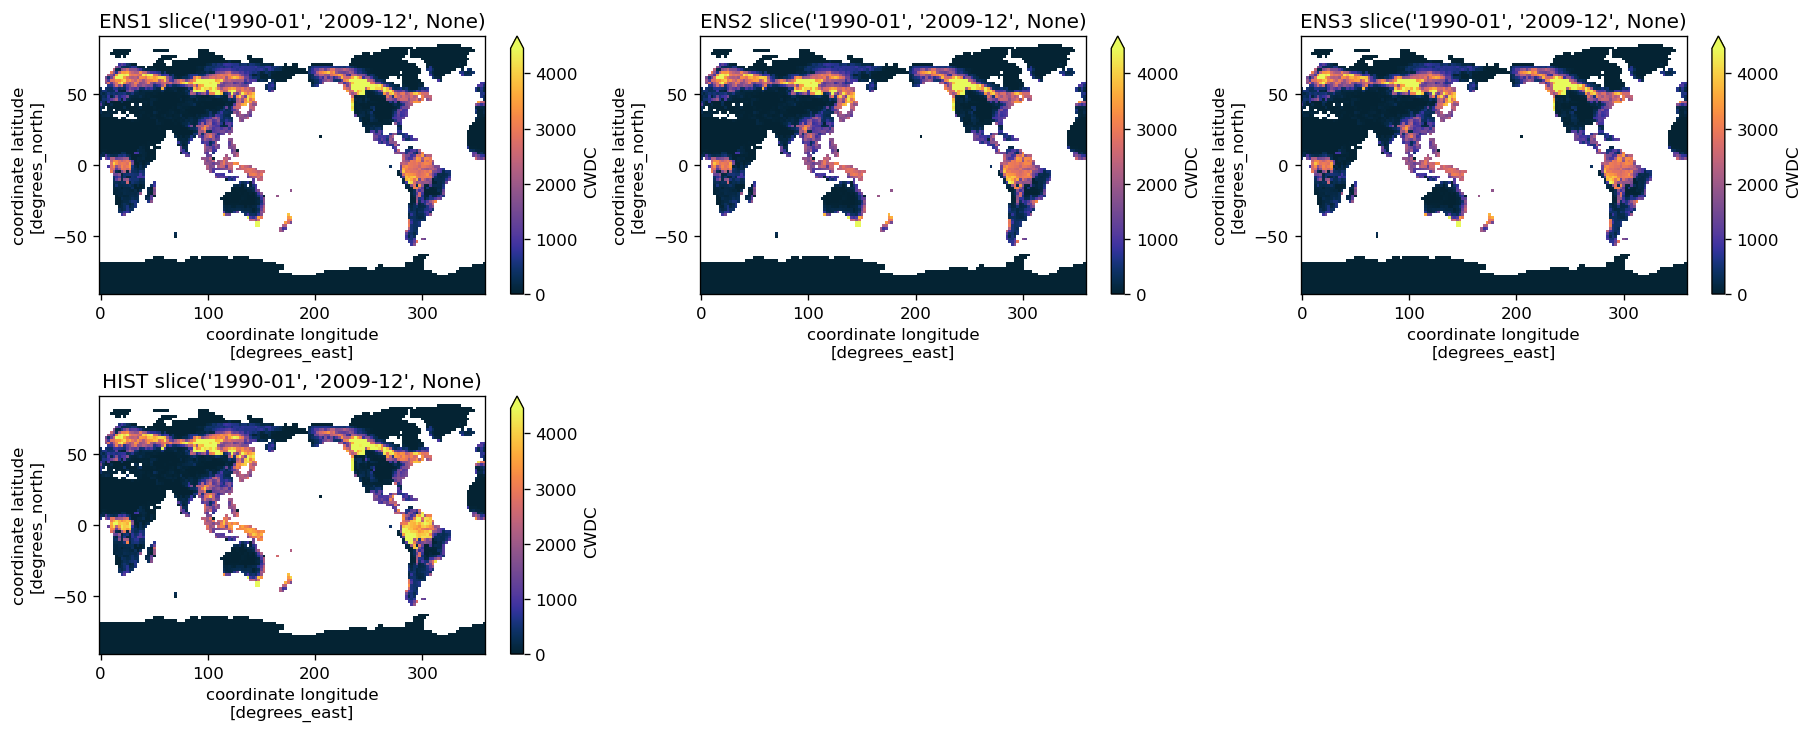

In [ ]:
fig, ax = compare_maps("CWDC", cmap=cmo.thermal, vmin=0, robust=True)
ax[4].remove()

WOODC timeseries not avail for PISO


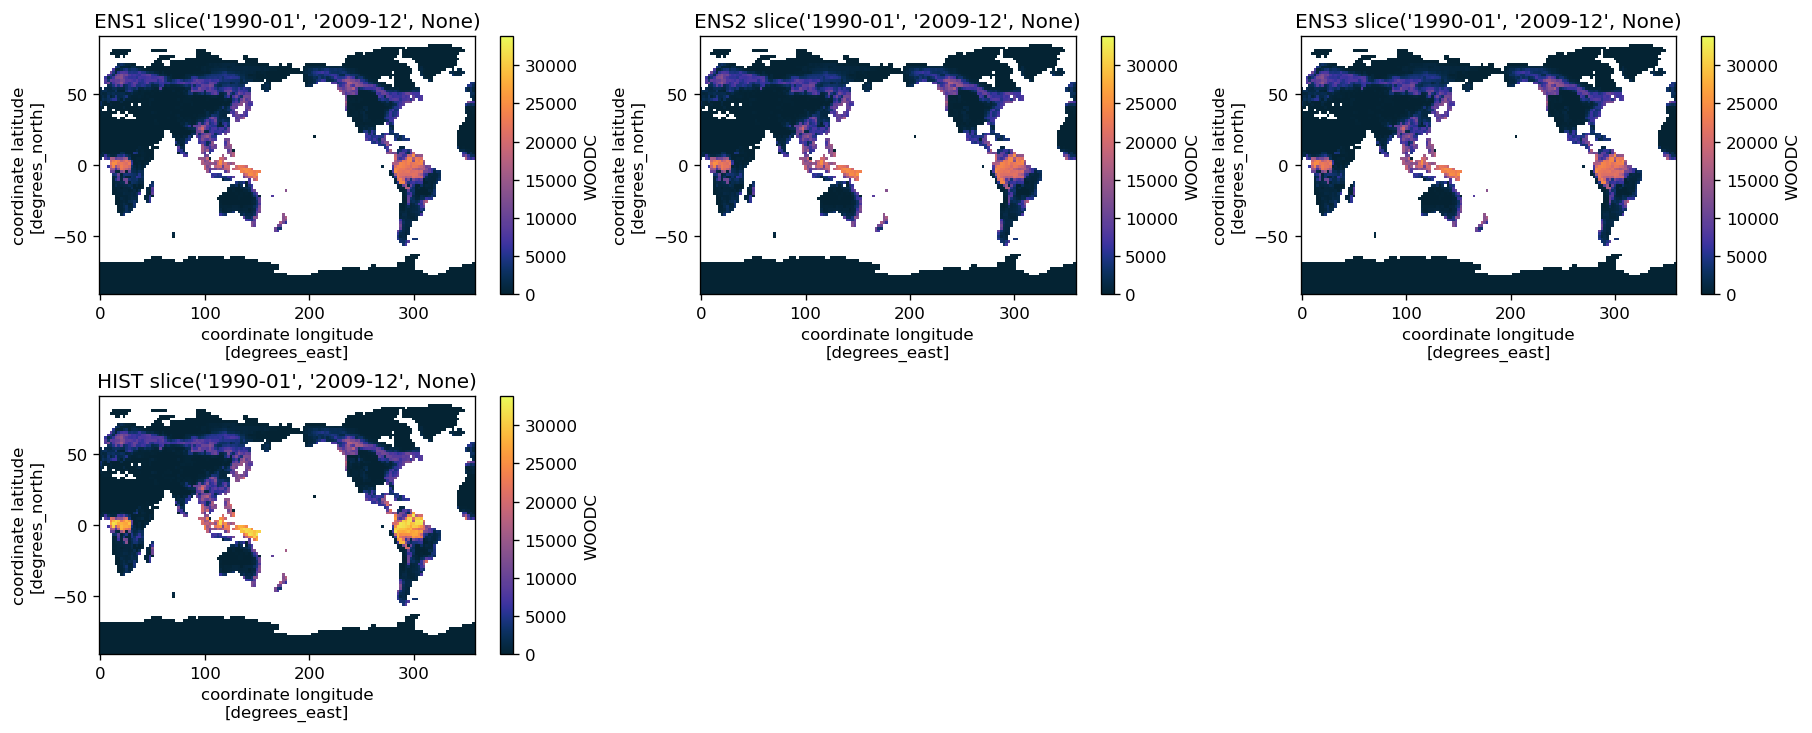

In [ ]:
fig, ax = compare_maps("WOODC", cmap=cmo.thermal)
ax[4].remove()

WOODC timeseries not avail for PISO


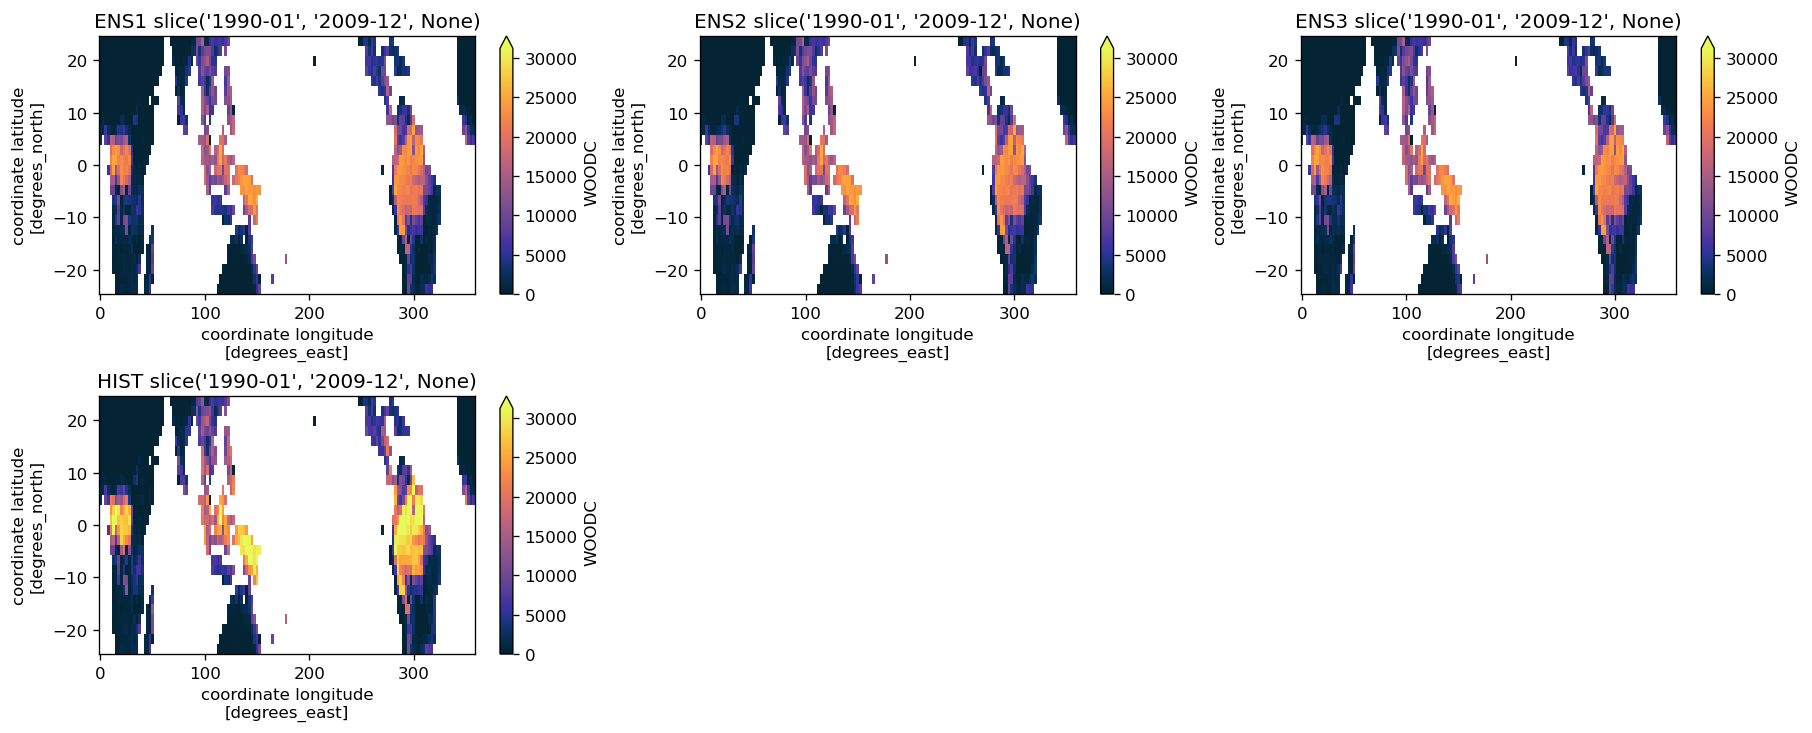

In [ ]:
fig, ax = compare_maps("WOODC", lat=[-25, 25], cmap=cmo.thermal, robust=True)
ax[4].remove()

TOTECOSYSC timeseries not avail for PISO


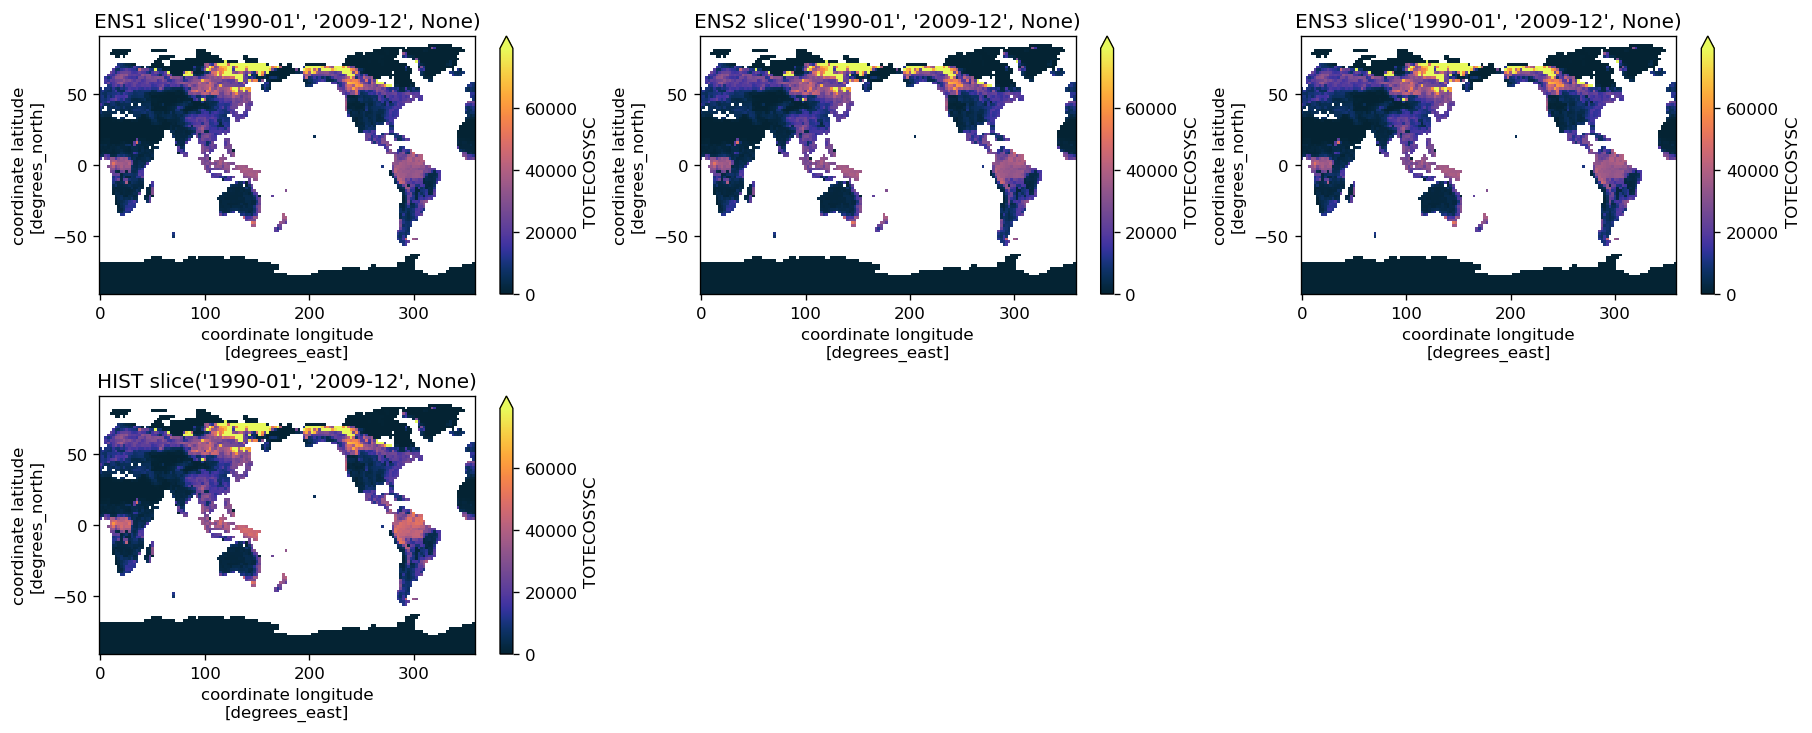

In [ ]:
fig, ax = compare_maps("TOTECOSYSC", cmap=cmo.thermal, robust=True)
ax[4].remove()

TOTECOSYSC timeseries not avail for PISO


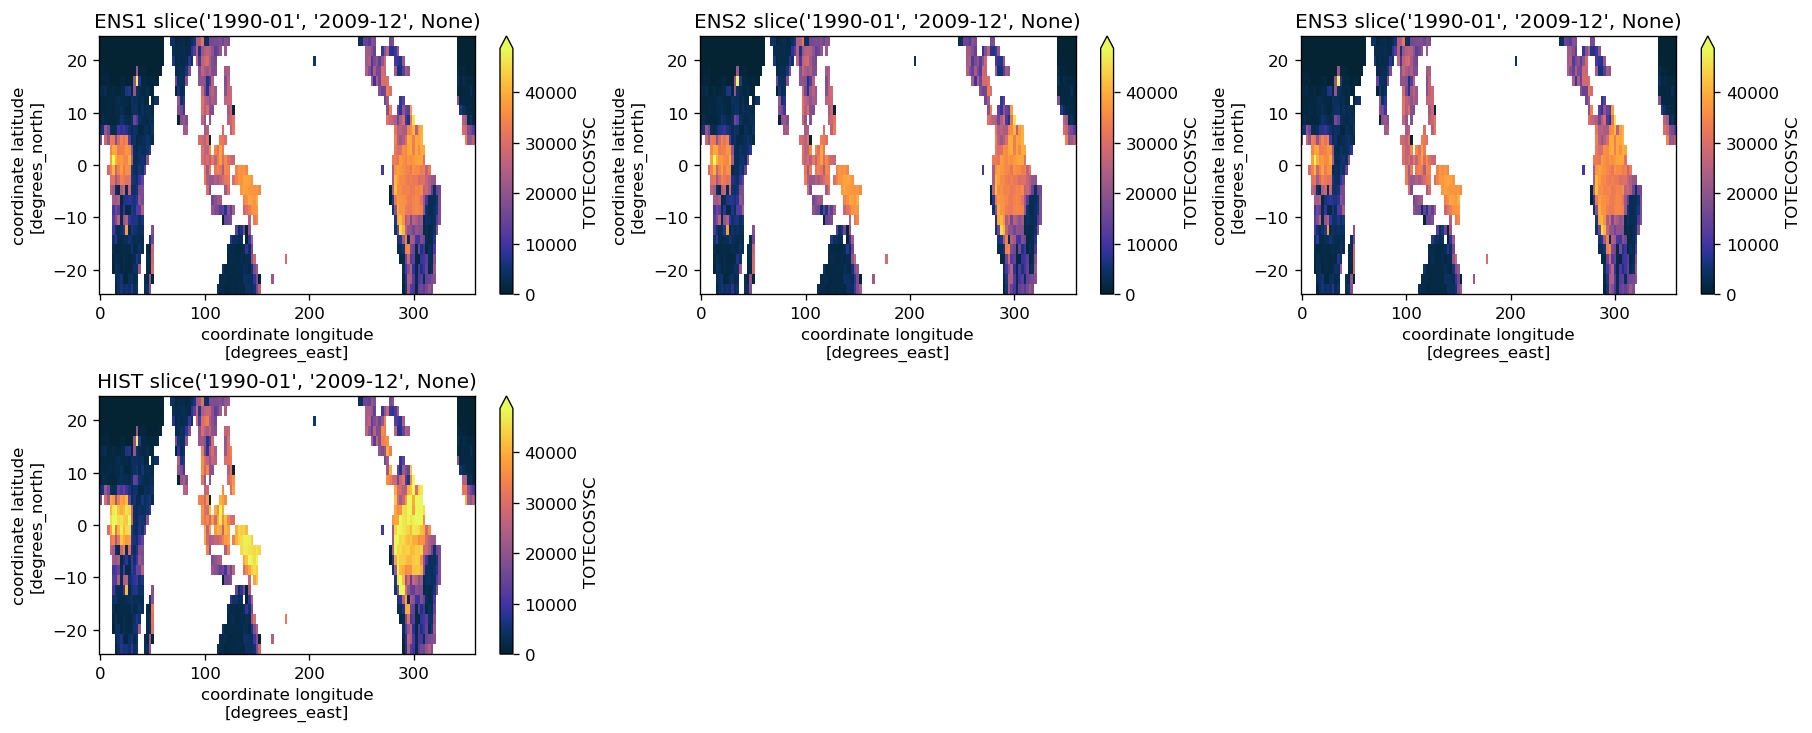

In [ ]:
fig, ax = compare_maps("TOTECOSYSC", lat=[-25, 25], cmap=cmo.thermal, robust=True)
ax[4].remove()

LEAFC timeseries not avail for PISO


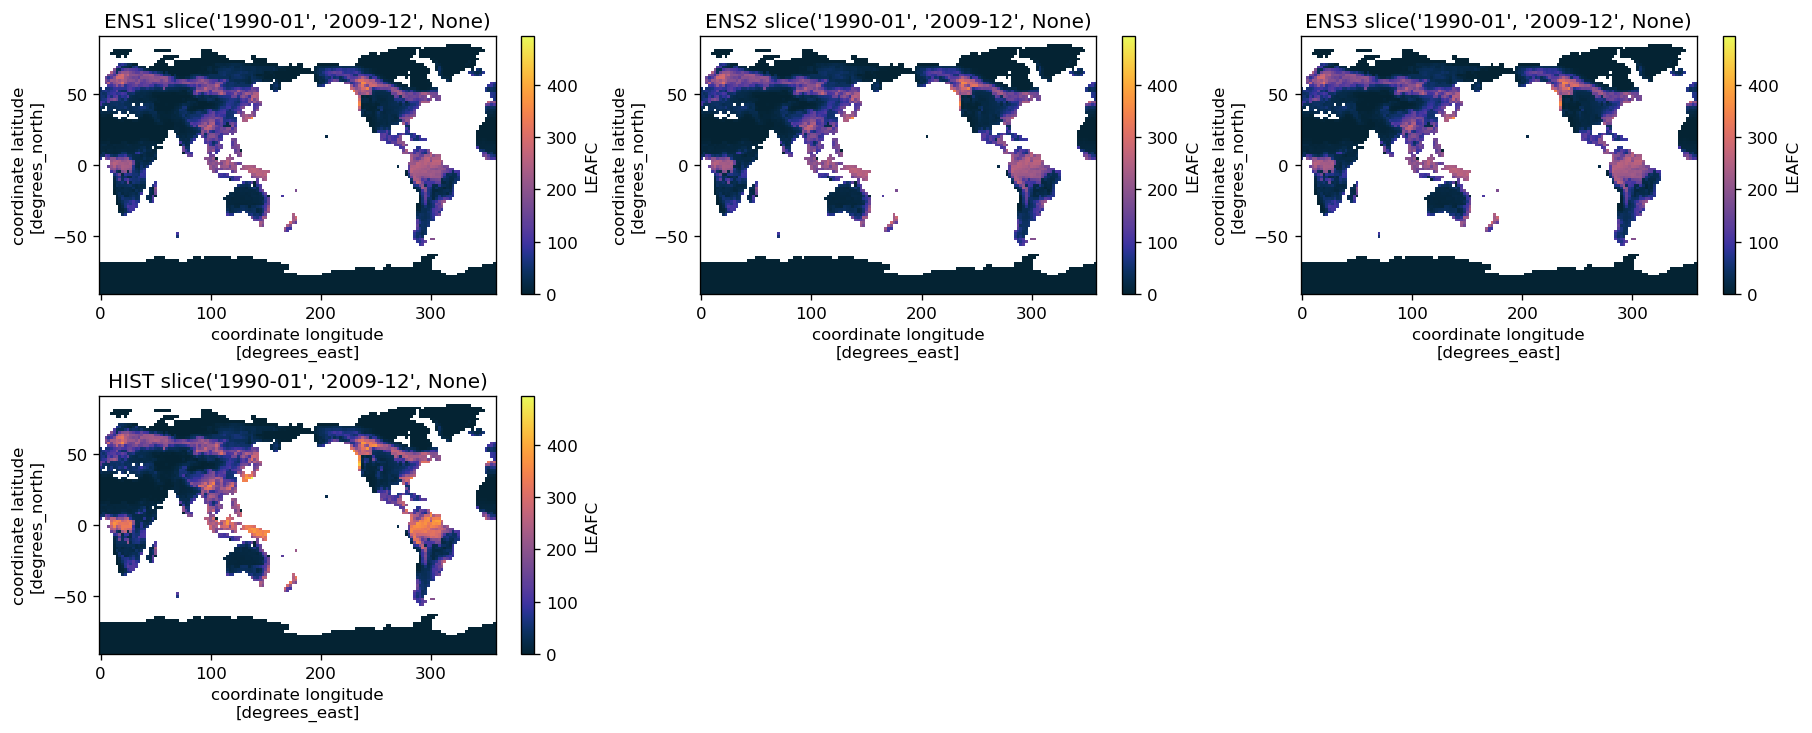

In [ ]:
fig, ax = compare_maps("LEAFC", cmap=cmo.thermal)
ax[4].remove()

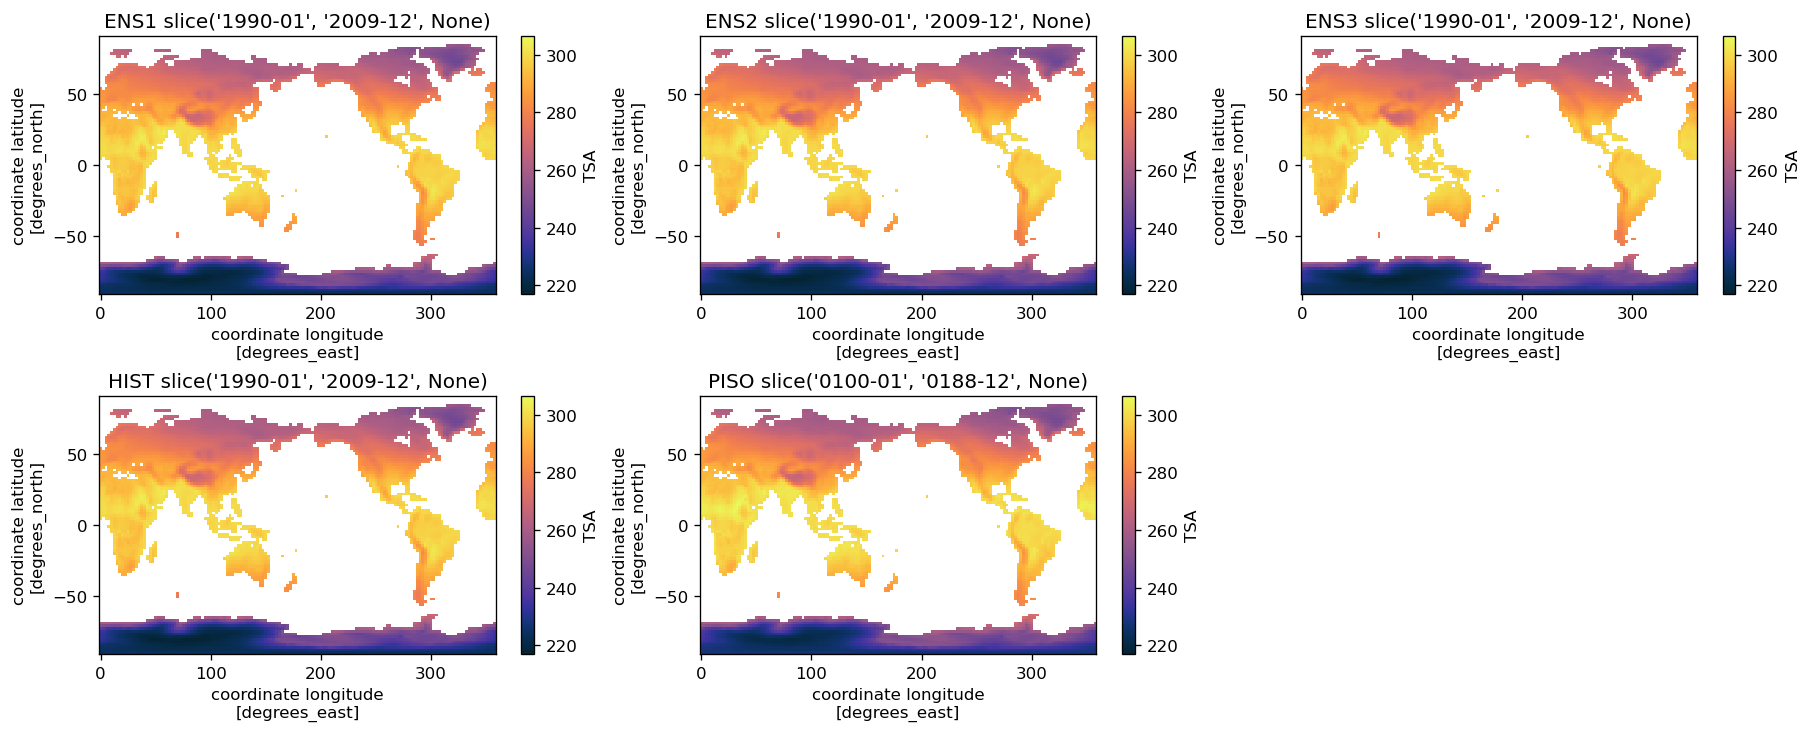

In [ ]:
compare_maps("TSA", cmap=cmo.thermal);

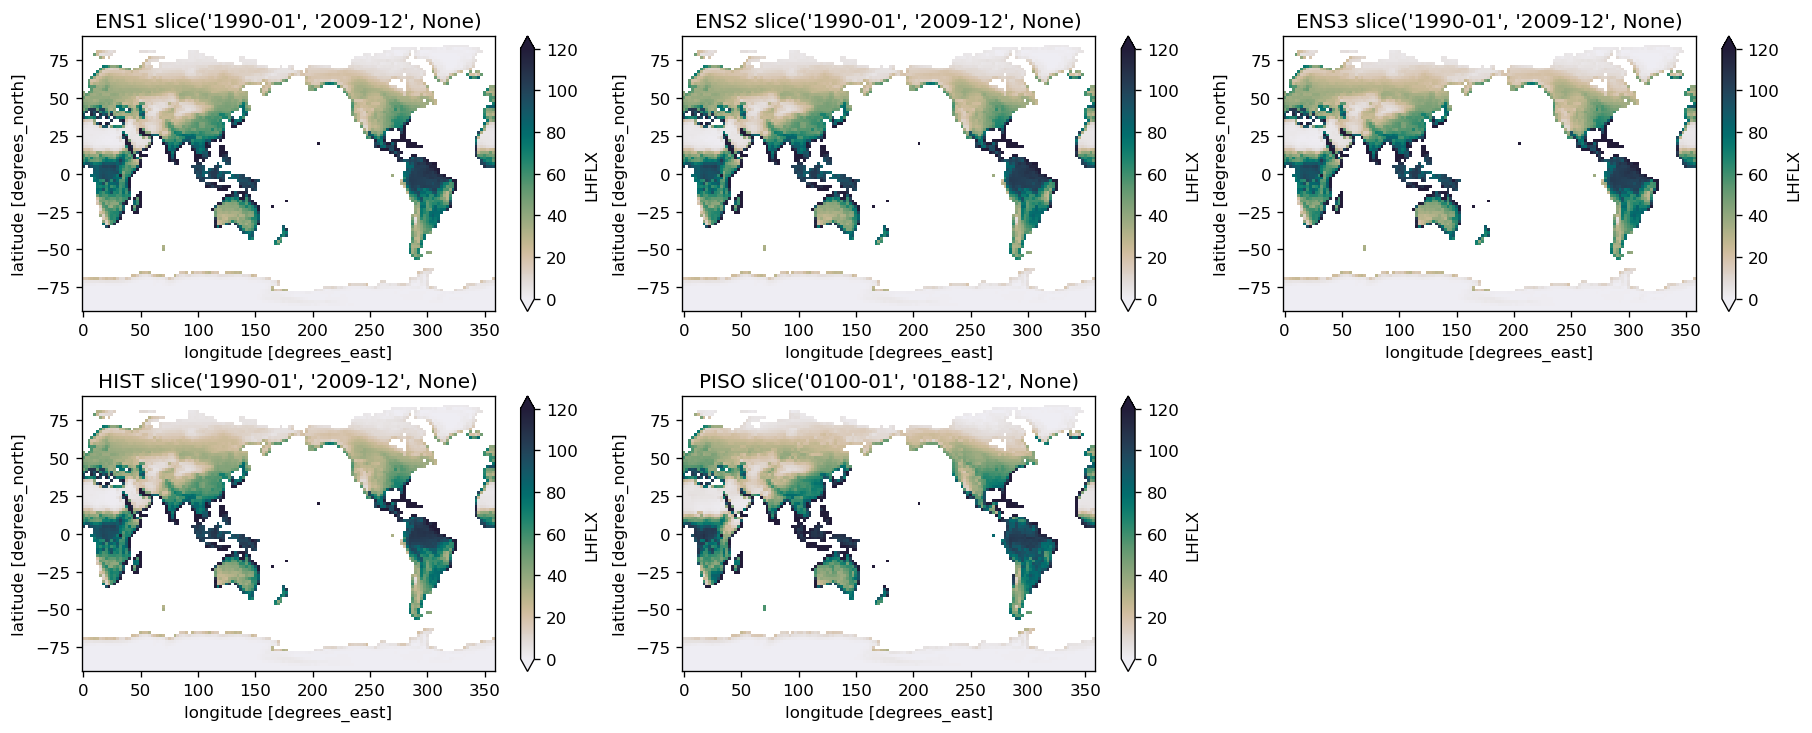

In [ ]:
compare_maps("LHFLX", cmap=cmo.rain, land_only=True, vmin=0, vmax=120);

# Maps of differences

In [6]:
cmipa = dict()
for var in cmip.keys():
    print(var)

    if isinstance(cmip[var], list):
        tmp = (cmip[var][0] + cmip[var][1] + cmip[var][2]) / len(cmip[var])
        cmipa[var] = tmp.copy(deep=True)
    else:
        cmipa[var] = cmip[var].copy(deep=True)

TREFHT
LHFLX
TLAI
GPP
HTOP
TSA
landarea
landweights
areaweights


Text(0.5, 1.0, 'Delta TLAI, coupPPE-hist $-$ CMIP6-AMIP-2deg')

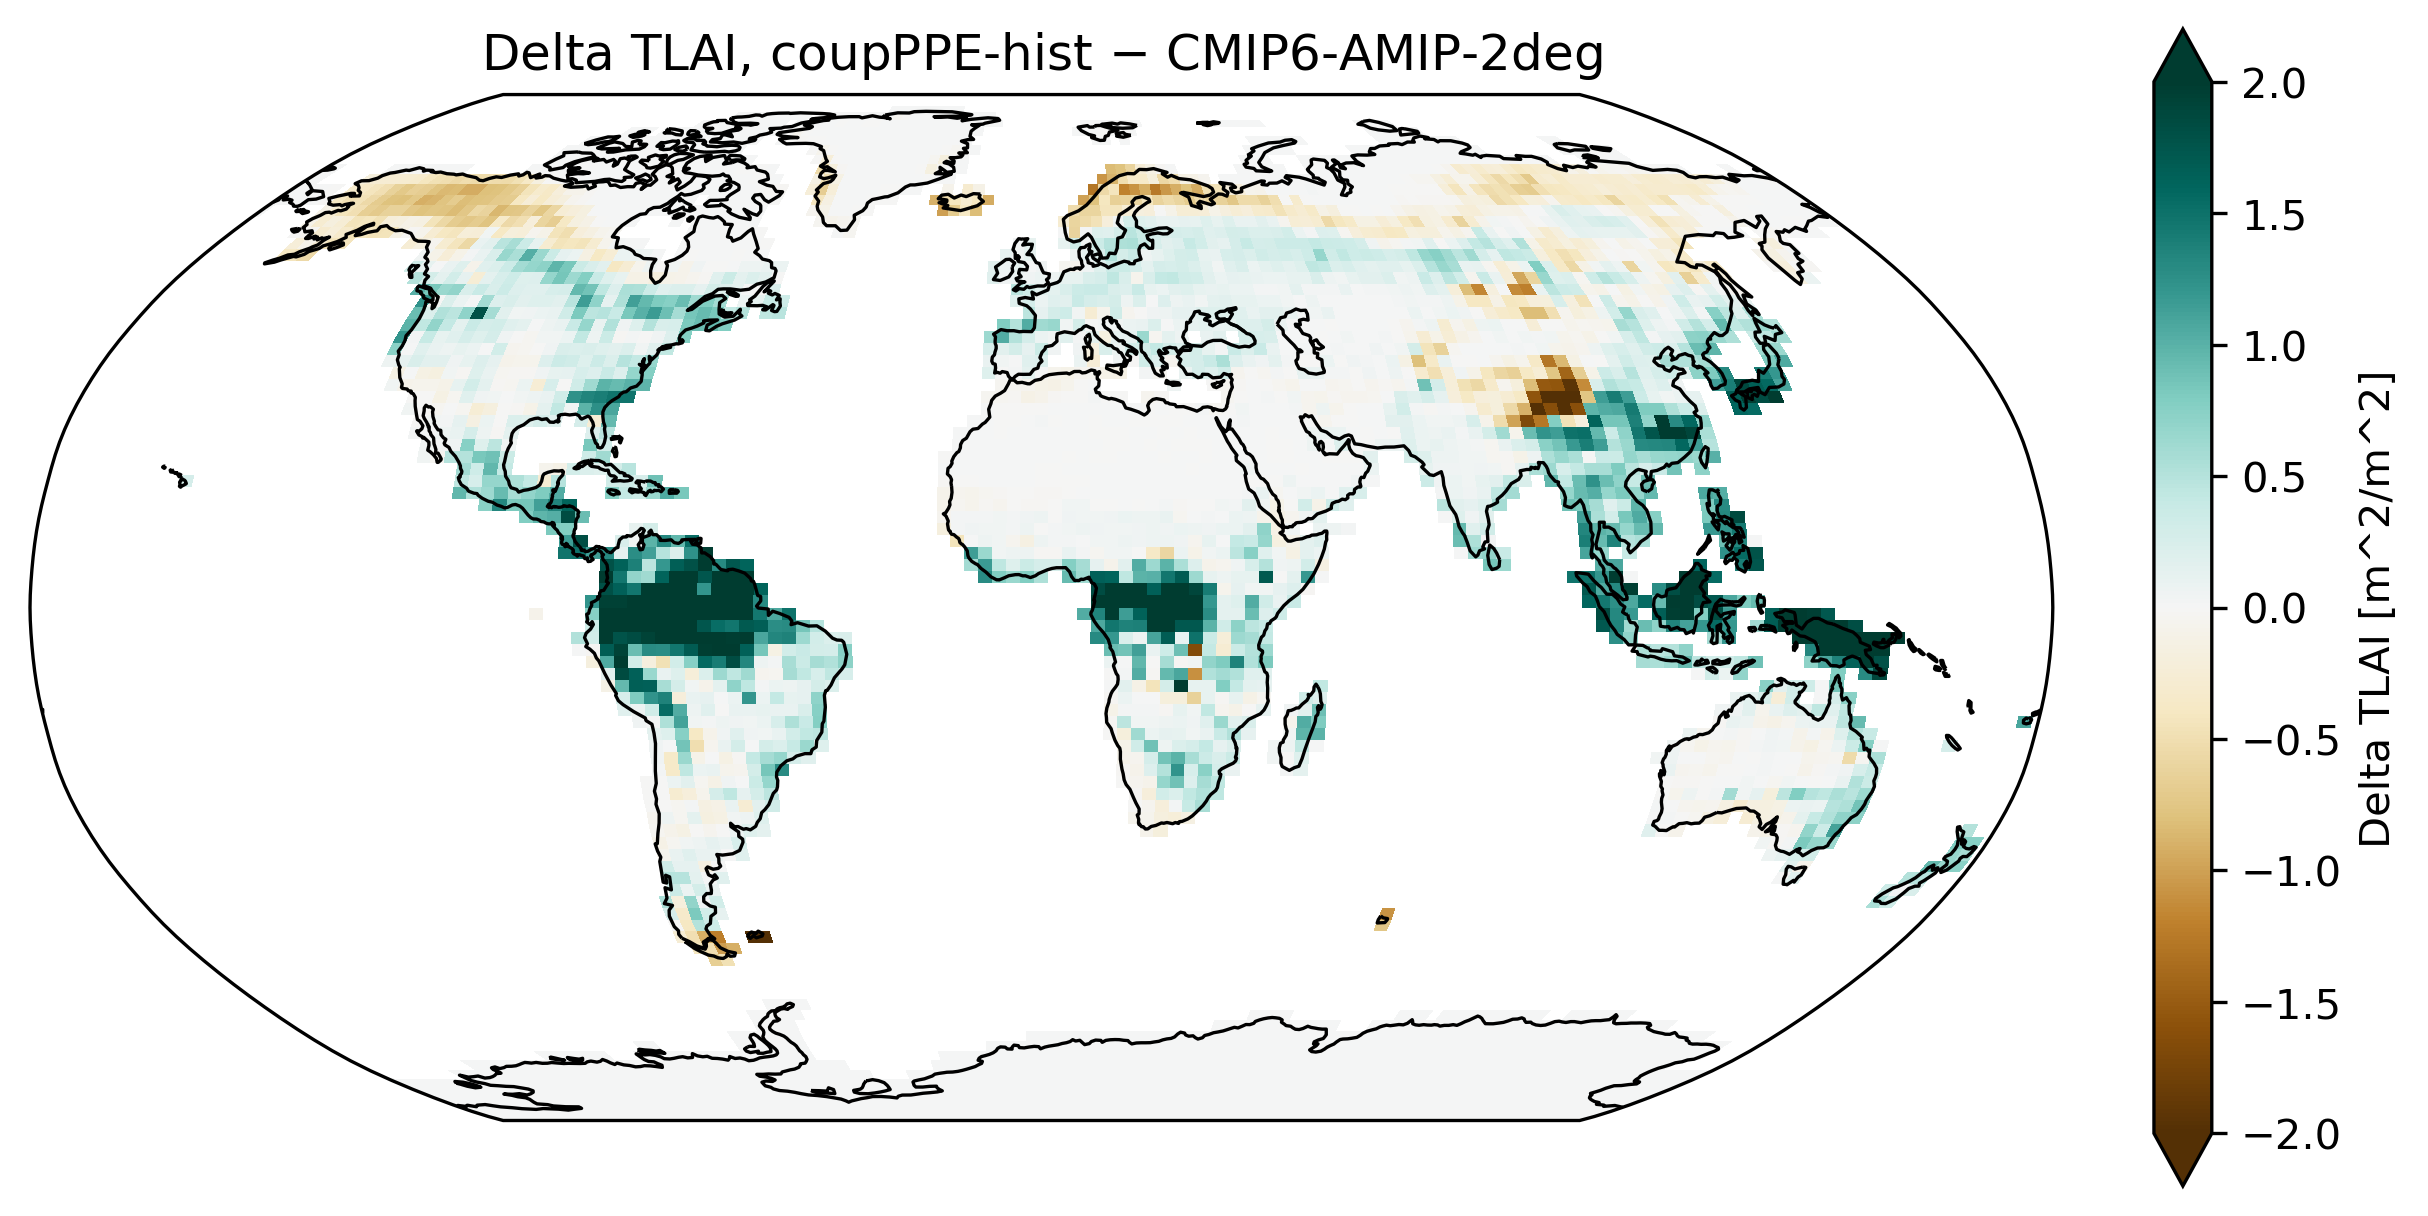

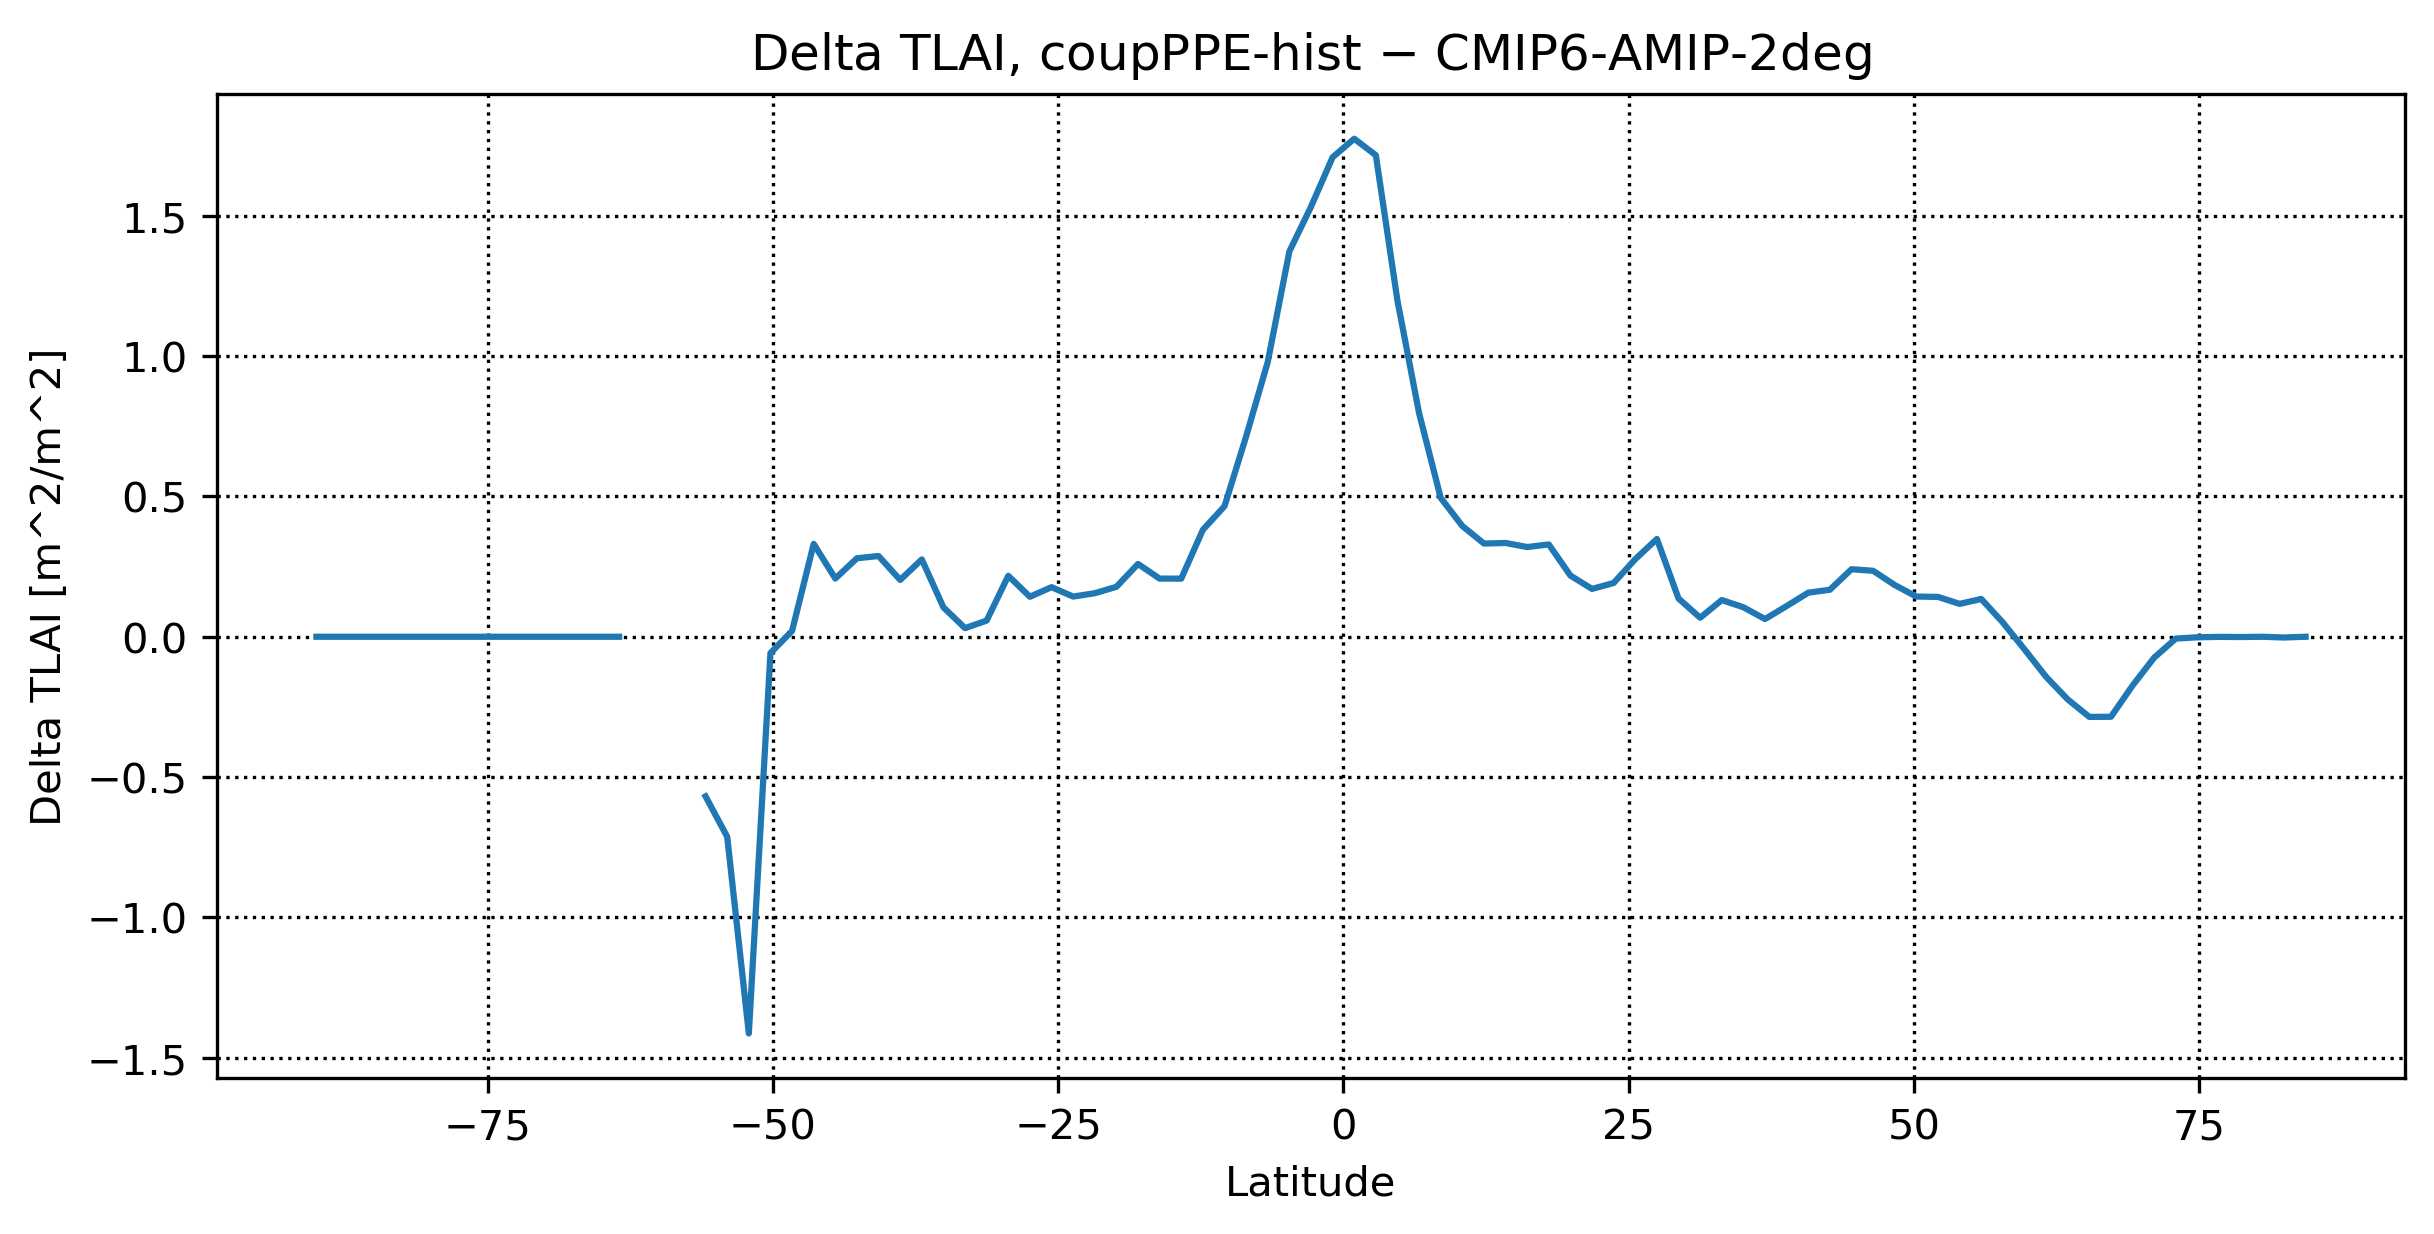

In [130]:
var = "TLAI"
start = "1990-01"
end = "2009-12"

tslice = slice(start, end)
hist_tavg = hist[var].sel(time=tslice).mean(dim="time")
cmipa_tavg = cmipa[var].sel(time=tslice).mean(dim="time")

fig, ax = plt.subplots(figsize=(8, 4), layout="constrained", subplot_kw={"projection": ccrs.Robinson()}, dpi=300)
(hist_tavg - cmipa_tavg).plot(ax=ax, transform=ccrs.PlateCarree(), cmap="BrBG", vmin=-2, vmax=2, extend="both", cbar_kwargs={"label": f"Delta {var} [{hist[var].units}]"})
ax.coastlines(lw=0.8, color="k")
ax.set_title(f"Delta {var}, coupPPE-hist $-$ CMIP6-AMIP-2deg")

fig, ax = plt.subplots(figsize=(8, 4), layout="constrained", dpi=300)
(hist_tavg - cmipa_tavg).mean(dim="lon").plot(ax=ax)
ax.grid(c="k", lw=0.8, ls=":")
ax.set_ylabel(f"Delta {var} [{hist[var].units}]")
ax.set_xlabel("Latitude")
ax.set_title(f"Delta {var}, coupPPE-hist $-$ CMIP6-AMIP-2deg")

In [46]:
hist[var].name

'TLAI'

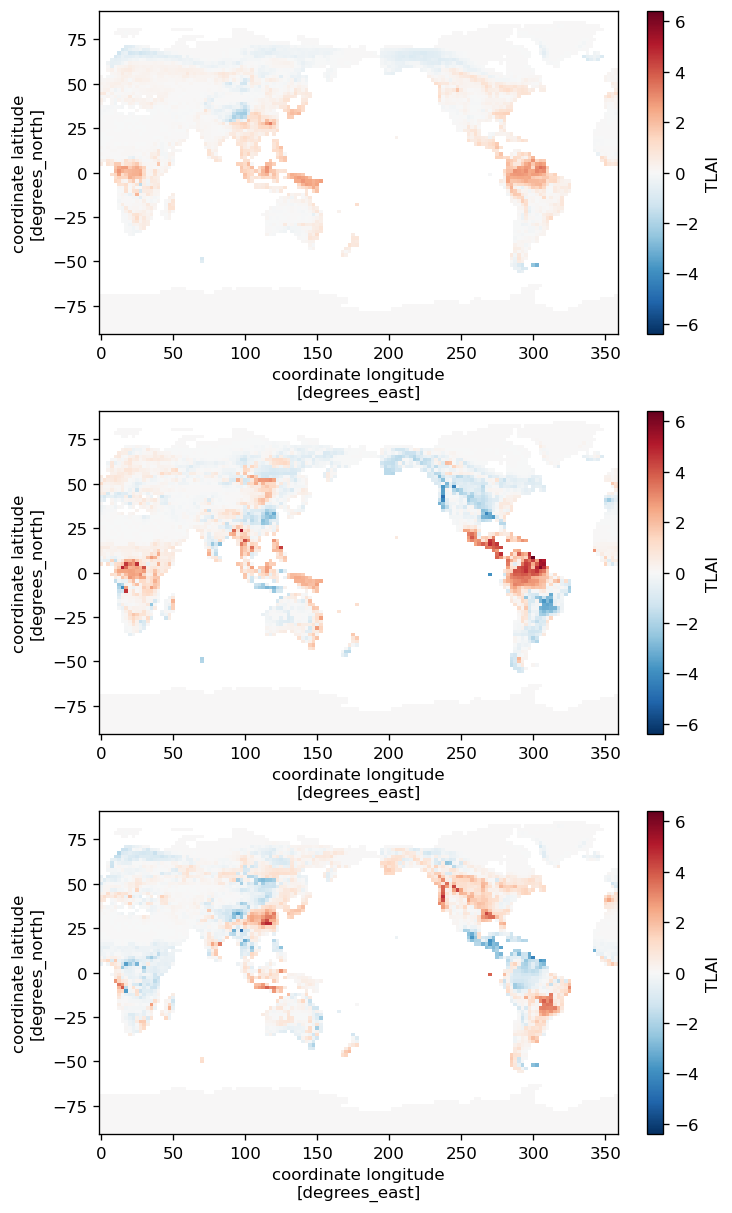

In [22]:
# plot HIST—ENSavg and PISO—ENSavg and HIST—PISO

var = "TLAI"
tslice = slice("1990-01", "2009-12")

hist_tavg = hist[var].sel(time=tslice).mean(dim="time")
cmipa_tavg = cmipa[var].sel(time=tslice).mean(dim="time")
piso_tavg = piso[var].mean(dim="time")

fig, ax = plt.subplots(3, 1, figsize=(6, 10), layout="constrained")
(hist_tavg - cmipa_tavg).plot(ax=ax[0])
(hist_tavg - piso_tavg).plot(ax=ax[1])
(piso_tavg - cmipa_tavg).plot(ax=ax[2])

# Find the min and max values across all plotted maps for consistent colorbars
vmins = []
vmaxs = []
for i in range(3):
    im = ax[i].collections[0]
    vmins.append(im.get_clim()[0])
    vmaxs.append(im.get_clim()[1])
vmin = min(vmins)
vmax = max(vmaxs)
for i in range(3):
    im = ax[i].collections[0]
    im.set_clim(vmin, vmax)

Text(0.5, 1.0, 'CMIP3 - CMIP2')

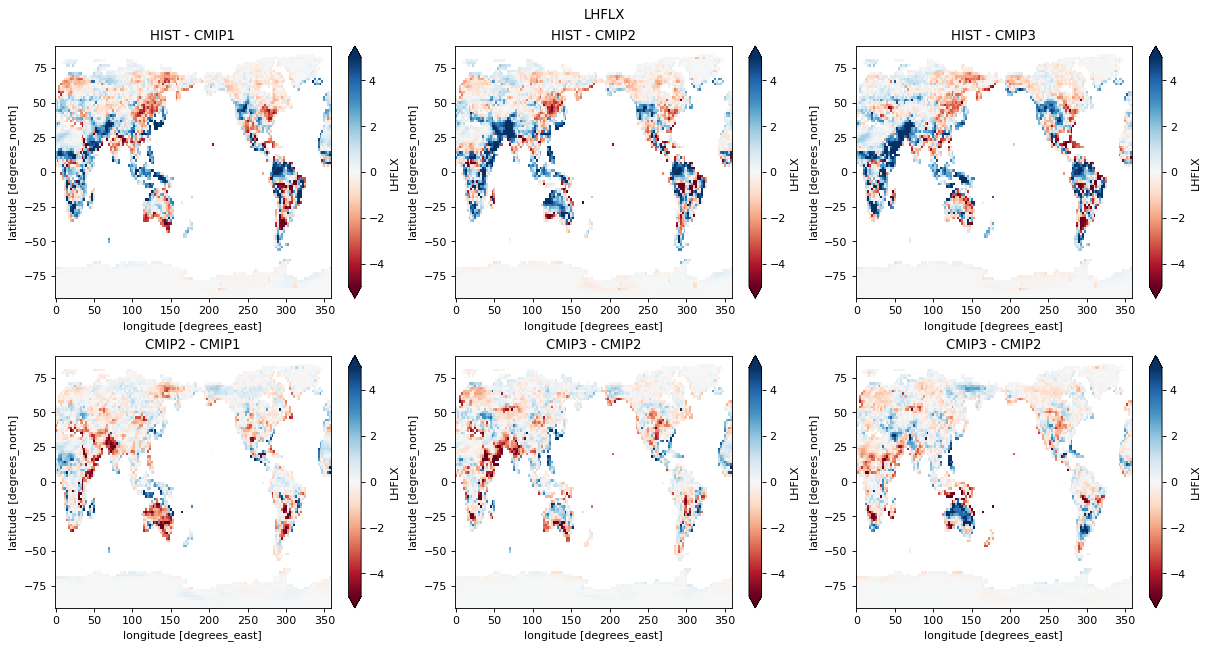

In [ ]:
var = "LHFLX"
vmin = -5
vmax = 5

fig, ax = plt.subplots(2, 3, figsize=(15, 8), layout="constrained")
ax = ax.flatten()
fig.suptitle(var)

(hist[var].sel(time=tslice).mean(dim="time") - cmip[var][0].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[0], robust=True, cmap="RdBu", vmin=vmin, vmax=vmax)
ax[0].set_title("HIST - CMIP1")

(hist[var].sel(time=tslice).mean(dim="time") - cmip[var][1].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[1], robust=True, cmap="RdBu", vmin=vmin, vmax=vmax)
ax[1].set_title("HIST - CMIP2")

(hist[var].sel(time=tslice).mean(dim="time") - cmip[var][2].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[2], robust=True, cmap="RdBu", vmin=vmin, vmax=vmax)
ax[2].set_title("HIST - CMIP3")

(cmip[var][1].sel(time=tslice).mean(dim="time") - cmip[var][0].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[3], robust=True, cmap="RdBu", vmin=vmin, vmax=vmax)
ax[3].set_title("CMIP2 - CMIP1")

(cmip[var][2].sel(time=tslice).mean(dim="time") - cmip[var][0].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[4], robust=True, cmap="RdBu", vmin=vmin, vmax=vmax)
ax[4].set_title("CMIP3 - CMIP2")

(cmip[var][2].sel(time=tslice).mean(dim="time") - cmip[var][1].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[5], robust=True, cmap="RdBu", vmin=vmin, vmax=vmax)
ax[5].set_title("CMIP3 - CMIP2")

Text(0.5, 1.0, 'CMIP3 - CMIP2')

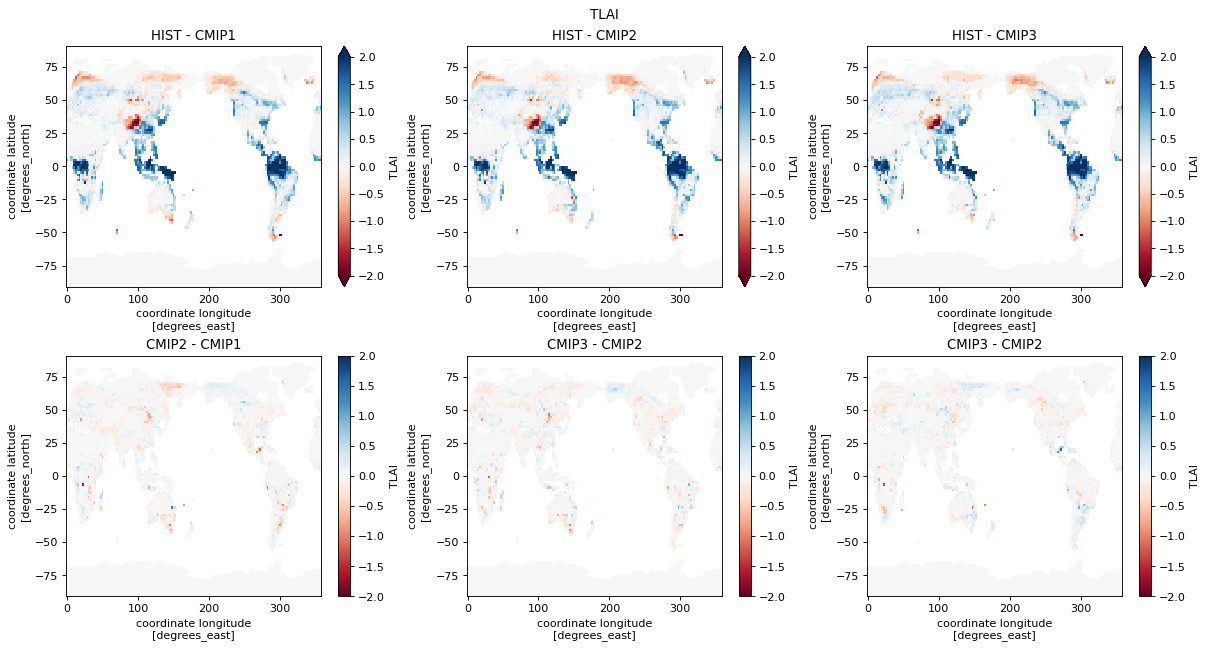

In [150]:
var = "TLAI"
vmin = -2
vmax = 2

fig, ax = plt.subplots(2, 3, figsize=(15, 8), layout="constrained")
ax = ax.flatten()
fig.suptitle(var)

(hist[var].sel(time=tslice).mean(dim="time") - cmip[var][0].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[0], robust=True, cmap="RdBu", vmin=vmin, vmax=vmax)
ax[0].set_title("HIST - CMIP1")

(hist[var].sel(time=tslice).mean(dim="time") - cmip[var][1].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[1], robust=True, cmap="RdBu", vmin=vmin, vmax=vmax)
ax[1].set_title("HIST - CMIP2")

(hist[var].sel(time=tslice).mean(dim="time") - cmip[var][2].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[2], robust=True, cmap="RdBu", vmin=vmin, vmax=vmax)
ax[2].set_title("HIST - CMIP3")

(cmip[var][1].sel(time=tslice).mean(dim="time") - cmip[var][0].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[3], robust=True, cmap="RdBu", vmin=vmin, vmax=vmax)
ax[3].set_title("CMIP2 - CMIP1")

(cmip[var][2].sel(time=tslice).mean(dim="time") - cmip[var][0].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[4], robust=True, cmap="RdBu", vmin=vmin, vmax=vmax)
ax[4].set_title("CMIP3 - CMIP2")

(cmip[var][2].sel(time=tslice).mean(dim="time") - cmip[var][1].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[5], robust=True, cmap="RdBu", vmin=vmin, vmax=vmax)
ax[5].set_title("CMIP3 - CMIP2")

Text(0.5, 1.0, 'CMIP3 - CMIP2')

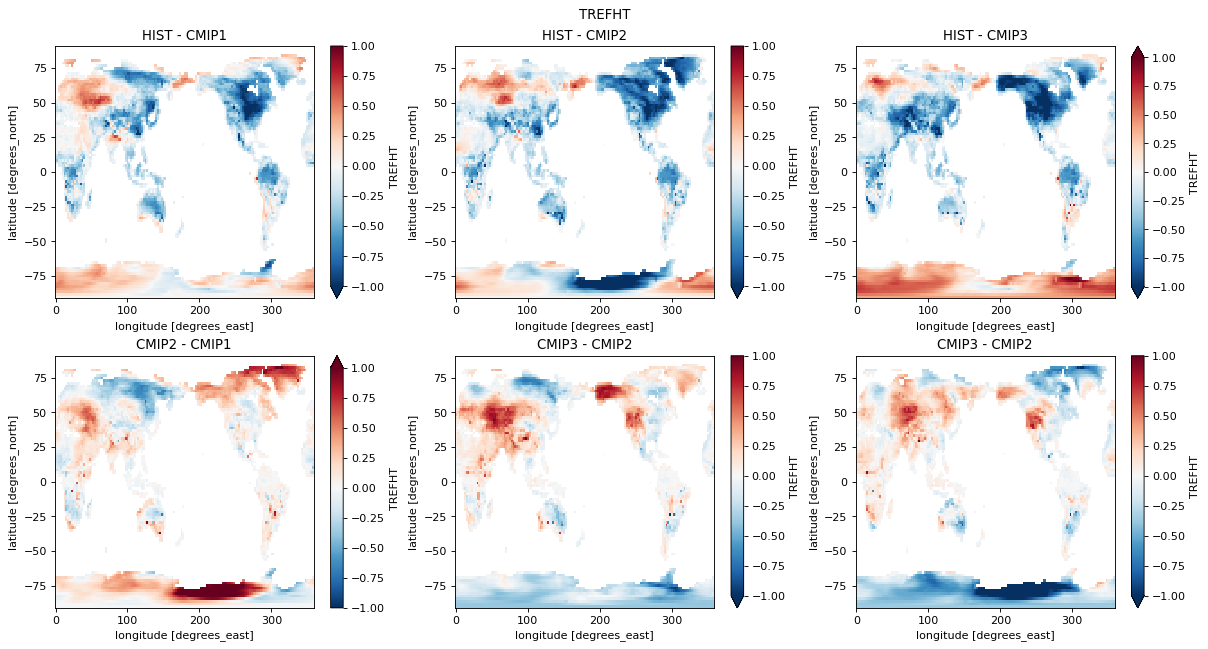

In [154]:
var = "TREFHT"
vmin = -1
vmax = 1

fig, ax = plt.subplots(2, 3, figsize=(15, 8), layout="constrained")
ax = ax.flatten()
fig.suptitle(var)

(hist[var].sel(time=tslice).mean(dim="time") - cmip[var][0].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[0], robust=True, cmap="RdBu_r", vmin=vmin, vmax=vmax)
ax[0].set_title("HIST - CMIP1")

(hist[var].sel(time=tslice).mean(dim="time") - cmip[var][1].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[1], robust=True, cmap="RdBu_r", vmin=vmin, vmax=vmax)
ax[1].set_title("HIST - CMIP2")

(hist[var].sel(time=tslice).mean(dim="time") - cmip[var][2].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[2], robust=True, cmap="RdBu_r", vmin=vmin, vmax=vmax)
ax[2].set_title("HIST - CMIP3")

(cmip[var][1].sel(time=tslice).mean(dim="time") - cmip[var][0].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[3], robust=True, cmap="RdBu_r", vmin=vmin, vmax=vmax)
ax[3].set_title("CMIP2 - CMIP1")

(cmip[var][2].sel(time=tslice).mean(dim="time") - cmip[var][0].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[4], robust=True, cmap="RdBu_r", vmin=vmin, vmax=vmax)
ax[4].set_title("CMIP3 - CMIP2")

(cmip[var][2].sel(time=tslice).mean(dim="time") - cmip[var][1].sel(time=tslice).mean(dim="time")).where(~np.isnan(hist["landarea"])).plot(ax=ax[5], robust=True, cmap="RdBu_r", vmin=vmin, vmax=vmax)
ax[5].set_title("CMIP3 - CMIP2")

Text(0.5, 1.0, 'percent change in LHFLX over land (HIST - CMIP1) / CMIP1 * 100')

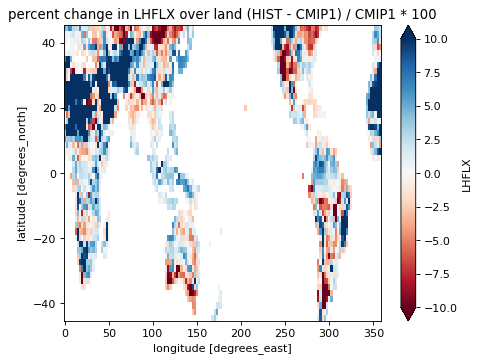

In [134]:
((hist[var].sel(time=tslice).mean(dim="time") - cmip[var][0].sel(time=tslice).mean(dim="time")) / (cmip[var][0].sel(time=tslice).mean(dim="time")) * 100).where(~np.isnan(hist["landarea"])).sel(lat=slice(-45, 45)).plot(vmin=-10, vmax=10, cmap="RdBu")
plt.title("percent change in LHFLX over land (HIST - CMIP1) / CMIP1 * 100")

Text(0.5, 1.0, 'percent change in LHFLX over land (CMIP2 - CMIP1) / CMIP1 * 100')

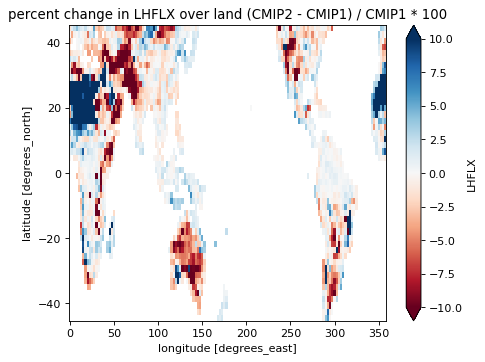

In [132]:
((cmip[var][1].sel(time=tslice).mean(dim="time") - cmip[var][0].sel(time=tslice).mean(dim="time")) / (cmip[var][0].sel(time=tslice).mean(dim="time")) * 100).where(~np.isnan(hist["landarea"])).sel(lat=slice(-45, 45)).plot(vmin=-10, vmax=10, cmap="RdBu")
plt.title("percent change in LHFLX over land (CMIP2 - CMIP1) / CMIP1 * 100")

Text(0.5, 1.0, 'percent change in LHFLX over land (CMIP3 - CMIP1) / CMIP1 * 100')

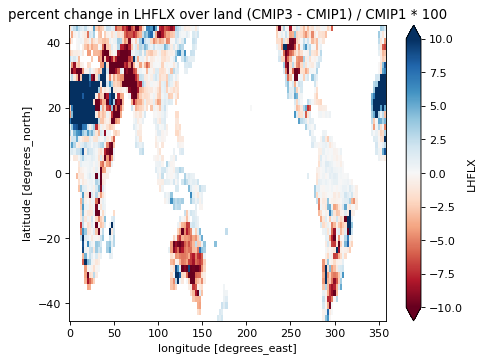

In [133]:
((cmip[var][1].sel(time=tslice).mean(dim="time") - cmip[var][0].sel(time=tslice).mean(dim="time")) / (cmip[var][0].sel(time=tslice).mean(dim="time")) * 100).where(~np.isnan(hist["landarea"])).sel(lat=slice(-45, 45)).plot(vmin=-10, vmax=10, cmap="RdBu")
plt.title("percent change in LHFLX over land (CMIP3 - CMIP1) / CMIP1 * 100")

In [282]:
# var = "TREFHT"

# cmip1_lr = linregress(np.arange(cmip1[var].time.size), cmip1[var].mean(dim=["lon", "lat"]).values)
# my_lr = linregress(np.arange(my[var].time.size), my[var].mean(dim=["lon", "lat"]).values)

# print(var)
# print("".ljust(10, "-") + "linear_regression" + "".ljust(10, "-"))
# print(cmip1_lr)
# print(my_lr)
# print("".ljust(10, "-") + "std_dev" + "".ljust(10, "-"))
# print(cmip1["TREFHT"].mean(dim=["lon", "lat"]).std(dim="time").values)
# print(my["TREFHT"].mean(dim=["lon", "lat"]).std(dim="time").values)